# Analysing solutions

## Setup

In [1]:
import itertools
import os
import re
import string
import xml.etree.ElementTree as ET

import cobra
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from matplotlib.ticker import MultipleLocator
from mmon_gcm.analysing import get_escher_map
from mmon_gcm.supermodel import SuperModel

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_theme()
sns.set_style("ticks")
sns.set_palette(
    sns.color_palette(
        [
            "#332288",
            "#88CCEE",
            "#44AA99",
            "#117733",
            "#999933",
            "#DDCC77",
            "#CC6677",
            "#882255",
            "#AA4499",
        ]
    )
)
colours = sns.color_palette()

params = {
    "xtick.labelsize": "large",
    "ytick.labelsize": "large",
    "axes.labelsize": "large",
    "axes.titlesize": "x-large",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "font.weight": "bold",
    "axes.spines.right": False,
    "axes.spines.top": False,
    "legend.frameon": False,
}
plt.rcParams.update(params)

In [4]:
def get_multiphase_fluxes(df, reaction):
    reaction_phased = [f"{reaction}_{i+1}" for i in range(4)]
    selected_df = df.loc[reaction_phased, "fluxes"]
    return selected_df

In [5]:
def convert_phases_to_times(df, phase_times=[6, 6.5, 18, 24]):
    df.index = pd.MultiIndex.from_tuples(
        [(row[0], phase_times[row[1] - 1]) for row in df.index], names=df.index.names
    )
    df = df.reorder_levels(["Phase", "Reaction"]).sort_index()
    df = df.append(pd.concat([df.loc[24]], keys=[0]))
    df = df.sort_index()
    df = df.reorder_levels(["Reaction", "Phase"]).sort_index()

    return df

In [6]:
def select_volume_based_on_id(reaction_id, SuperModel):
    total_gc_volume = SuperModel.get_volumes(per_guard_cell=False)

    if "total" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(per_guard_cell=False)
    elif "v_gc" in reaction_id:
        phase_volumes = total_gc_volume = (
            SuperModel.get_volumes(per_guard_cell=False) * SuperModel.Vac_frac
        )
    elif "c_gc" in reaction_id:
        phase_volumes = total_gc_volume = SuperModel.get_volumes(
            per_guard_cell=False
        ) * (1 - SuperModel.Vac_frac)
    elif "p_gc" in reaction_id:
        phase_volumes = [1] * 4
    else:
        raise ValueError(f"Don't know how to deal with {reaction_id}")

    return phase_volumes

In [7]:
def convert_to_conc(row, SuperModel, phases_in_df=[0, 6, 6.5, 18, 24]):
    phase = row.name[1]

    phase_conversion_dict = {
        phases_in_df[0]: 4,
        phases_in_df[1]: 1,
        phases_in_df[2]: 2,
        phases_in_df[3]: 3,
        phases_in_df[4]: 4,
    }

    phase_volumes = select_volume_based_on_id(row.name[0], SuperModel)

    volume_for_phase = phase_volumes[phase_conversion_dict[phase] - 1]

    return row / volume_for_phase

In [8]:
def get_metabolite_df(
    solutions_df, concentrations=True, total_mets=None, SuperModel=None
):
    if total_mets == None:
        total_mets = ["SUCROSE", "GLC", "MAL", "FRU", "K", "Cl", "CIT"]
    total_mets_reactions = [met + "_total_pseudolinker" for met in total_mets] + [
        "STARCH_p_gc_Linker"
    ]
    total_mets_reactions_phased = [
        f"{reaction}_{i+1}" for i in range(4) for reaction in total_mets_reactions
    ]
    met_df = (solutions_df.loc[total_mets_reactions]).copy()

    # change index to phase times instead of tags
    met_df = convert_phases_to_times(met_df)

    if concentrations == True:
        met_df = met_df.apply(convert_to_conc, args=([SuperModel]), axis=1)

    met_df = met_df.reorder_levels(["Phase", "Reaction"]).sort_index()

    met_df.index = pd.MultiIndex.from_tuples(
        [(index[0], index[1].split("_")[0]) for index in met_df.index],
        names=met_df.index.names,
    )

    return met_df

In [9]:
def get_closed_open_values(met_df_mm, light, atpase):
    open_closed_dict = {}

    for genotype in ["wt", "starchko"]:
        open_closed_dict[genotype] = {}
        open_closed_dict[genotype]["closed"] = met_df_mm.loc[
            ~(met_df_mm.index == (6, "STARCH"))
        ].loc[6, (light, atpase, genotype, "fluxes")]
        open_closed_dict[genotype]["open"] = met_df_mm.loc[
            ~(met_df_mm.index == (6.5, "STARCH"))
        ].loc[6.5, (light, atpase, genotype, "fluxes")]

    return open_closed_dict

In [10]:
def get_closed_open_values(met_df_mm, light, atpase):
    open_closed_dict = {}

    for genotype in ["wt", "starchko"]:
        open_closed_dict[genotype] = {}
        open_closed_dict[genotype]["closed"] = met_df_mm.loc[
            6, (light, atpase, genotype, "fluxes")
        ]
        open_closed_dict[genotype]["open"] = met_df_mm.loc[
            6.5, (light, atpase, genotype, "fluxes")
        ]

    return open_closed_dict

In [11]:
def get_totals_plot(specific_met_df):
    colours = ["#999999ff", "#ff7043ff"]
    mpl.rcParams["hatch.linewidth"] = 1.5
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios": [7, 1]})

    closed_metabolite_df = specific_met_df.loc[6.0].drop("STARCH")
    open_metabolite_df = specific_met_df.loc[6.5].drop("STARCH")

    # plot wt
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 - 0.05,
        closed_metabolite_df["wt"],
        color=colours[0],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
    )
    axs[0].bar(
        np.array(range(len(open_metabolite_df))) * 2 + 0.05,
        open_metabolite_df["wt"],
        color=colours[1],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
    )

    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 - 0.05,
        closed_metabolite_df["starchko"],
        color=colours[0],
        width=-0.3,
        align="edge",
        edgecolor="white",
        hatch="//",
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 + 0.05,
        open_metabolite_df["starchko"],
        color=colours[1],
        width=0.3,
        align="edge",
        edgecolor="white",
        hatch="//",
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 - 0.05,
        closed_metabolite_df["starchko"],
        color="none",
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
    )
    axs[0].bar(
        np.array(range(len(closed_metabolite_df))) * 2 + 1 + 0.05,
        open_metabolite_df["starchko"],
        color="none",
        width=0.3,
        align="edge",
        edgecolor=colours[1],
    )

    x_ticks_pad = 12
    axs[0].tick_params(axis="x", which="both", bottom=False, pad=x_ticks_pad)
    axs[1].tick_params(axis="x", which="both", bottom=False, pad=x_ticks_pad)

    starch_closed = specific_met_df.loc[(6.0, "STARCH")]
    starch_open = specific_met_df.loc[(6.5, "STARCH")]

    axs[1].bar(
        -0.05,
        starch_closed["wt"],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
        color=colours[0],
    )
    axs[1].bar(
        0.05,
        starch_open["wt"],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
        color=colours[1],
    )

    axs[1].bar(
        1 - 0.05,
        starch_closed["starchko"],
        width=-0.3,
        align="edge",
        edgecolor=colours[0],
        color=colours[0],
        hatch="//",
    )
    axs[1].bar(
        1 + 0.05,
        starch_open["starchko"],
        width=0.3,
        align="edge",
        edgecolor=colours[1],
        color=colours[1],
        hatch="//",
    )

    main_x_tick_labels = [
        name[0] + name[1:3].lower() for name in open_metabolite_df.index
    ]

    main_x_tick_labels_superscripted = []
    for label in main_x_tick_labels:
        if label == "K":
            new_label = r"K$^+$"
        elif label == "Cl":
            new_label = r"Cl$^-$"
        else:
            new_label = label
        main_x_tick_labels_superscripted.append(new_label)

    main_x_tick_labels = main_x_tick_labels_superscripted

    main_x_ticks = np.array(range(len(closed_metabolite_df))) * 2 + 0.5

    ax0_y_max = 60

    axs[0].set_xticks(main_x_ticks)
    axs[0].set_xticklabels(main_x_tick_labels)
    axs[0].set_ylim(-0.1, ax0_y_max)
    axs[0].set_xlim(-0.5, 13.5)
    axs[0].set_ylabel(r"Osmolyte concentration (mM)")
    axs[0].yaxis.set_major_locator(MultipleLocator(10))
    # axs[0].yaxis.set_minor_locator(AutoMinorLocator(2))

    for x_loc in [(x - 1) * 2 + 1.5 for x in range(len(closed_metabolite_df))]:
        axs[0].hlines(
            -3.7, x_loc + 0.1, x_loc + 1.9, clip_on=False, color="black", alpha=0.9
        )
        for offset, label in zip([0.5, 1.5], ["WT", "KO"]):
            axs[0].text(
                x_loc + offset, -2, label, ha="center", va="center", size="small"
            )

    starch_x_tick_labels = ["Starch"]
    starch_x_ticks = [0.5]

    ax1_y_max = 14

    axs[1].set_xticks(starch_x_ticks)
    axs[1].set_xticklabels(starch_x_tick_labels)
    axs[1].set_ylim(-0.1 * ax1_y_max / ax0_y_max, ax1_y_max)
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_major_locator(MultipleLocator(2))
    # axs[1].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[1].spines["right"].set_visible(True)
    axs[1].spines["left"].set_visible(False)
    axs[1].set_ylabel(r"Amount (fmol$\cdot$GC$^{-1}$)")

    for x_loc in [(x - 1) * 2 + 1.5 for x in [0]]:
        axs[1].hlines(
            -3.7 * ax1_y_max / ax0_y_max,
            x_loc + 0.1,
            x_loc + 2,
            clip_on=False,
            color="black",
            alpha=0.9,
        )
        for offset, label in zip([0.5, 1.5], ["WT", "KO"]):
            axs[1].text(
                x_loc + offset,
                -2 * ax1_y_max / ax0_y_max,
                label,
                ha="center",
                va="center",
                size="small",
            )

    colors = {"EoN": "#999999ff", "30 mins": "#ff7043ff"}
    labels = list(colors.keys())
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
    # plt.legend(handles, labels)

    plt.subplots_adjust(wspace=0.05)

    return fig

In [12]:
def getgcdiagram(
    modeldf,
    modelname,
    condition_label,
    genotype_label,
    scale_height,
    minimal=True,
    flipped=False,
    display_svg=True,
    debug=False,
    brokenaxis=False,
    aspser=False,
    save_png=True,
):
    if minimal == True:
        if aspser == True:
            tree = ET.parse("../inputs/fluxmap_template_aspserminimal.svg")
            root = tree.getroot
        else:
            tree = ET.parse("../inputs/fluxmap_template_minimal.svg")
            root = tree.getroot
    else:
        tree = ET.parse("../inputs/fluxmap_template.svg")
        root = updatetextnames(tree, condition_label, genotype_label, debug=debug)

    # get the background and the flipped background, and set the opacity of the wrong one to 0
    background = getelement(
        tree,
        condition_label=condition_label,
        genotype_label=genotype_label,
        compartment_label="Background",
        debug=debug,
    )
    background_flipped = getelement(
        tree,
        condition_label=condition_label,
        genotype_label=genotype_label,
        compartment_label="Background_flipped",
        debug=debug,
    )

    if flipped == True:
        updateelementopacity(background, 0)
        updateelementopacity(background_flipped, 1)
    else:
        updateelementopacity(background, 1)
        updateelementopacity(background_flipped, 0)

    if minimal is not True:
        # get the scale bar, either keep the hatched or don't, and set the height to the scale conc specified
        for phase_label in ["EoN", "30", "EoN_hatched", "30_hatched"]:
            scale_bar_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label="other",
                metabolite_label="scale",
                phase_label=phase_label,
                debug=debug,
            )
            if "hatched" in phase_label:
                updateelementopacity(scale_bar_element, int(flipped))
            else:
                updateelementopacity(scale_bar_element, int(not flipped))
            updateelementheight(scale_bar_element, scale_height)

    for row in modeldf.iterrows():
        compartment_label = row[0][1]
        metabolite_label = row[0][0]

        if debug == True:
            print(row[0], row[1])

        try:
            eon_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="EoN",
                debug=debug,
            )
            thirty_element = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="30",
                debug=debug,
            )

            eon_element_hatched = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="EoN_hatched",
                debug=debug,
            )
            thirty_element_hatched = getelement(
                tree,
                condition_label=condition_label,
                genotype_label=genotype_label,
                compartment_label=compartment_label,
                metabolite_label=metabolite_label,
                phase_label="30_hatched",
                debug=debug,
            )

            if flipped == True:
                updateelementopacity(eon_element, 0)
                updateelementopacity(eon_element_hatched, 1)
                updateelementopacity(thirty_element, 0)
                updateelementopacity(thirty_element_hatched, 1)
            else:
                updateelementopacity(eon_element, 1)
                updateelementopacity(eon_element_hatched, 0)
                updateelementopacity(thirty_element, 1)
                updateelementopacity(thirty_element_hatched, 0)

            if row[1]["EoN"] <= 0.0001:
                updateelementheight(eon_element, 0.5)
                updateelementheight(eon_element_hatched, 0.5)
            else:
                updateelementheight(eon_element, row[1]["EoN"])
                updateelementheight(eon_element_hatched, row[1]["EoN"])

            if row[1]["30 mins"] <= 0.0001:
                updateelementheight(thirty_element, 0.5)
                updateelementheight(thirty_element_hatched, 0.5)
            else:
                updateelementheight(thirty_element, row[1]["30 mins"])
                updateelementheight(thirty_element_hatched, row[1]["30 mins"])

        except AttributeError:
            print(f"{row[0]} not in template")

    svgpath = f"../outputs/flux_maps/{modelname}.svg"
    tree.write(svgpath, encoding="UTF-8", xml_declaration=True)
    if display_svg == True:
        display(SVG(svgpath))

    return svgpath


def getelement(
    tree,
    condition_label,
    genotype_label=None,
    compartment_label=None,
    metabolite_label=None,
    phase_label=None,
    debug=False,
):
    if debug == True:
        print(
            "Trying: ",
            condition_label,
            genotype_label,
            compartment_label,
            metabolite_label,
            phase_label,
        )
    root = tree.getroot()
    if debug == True:
        print("Got root", end=" ")
    for condition in root.findall("{http://www.w3.org/2000/svg}g"):
        if (
            condition.get("{http://www.inkscape.org/namespaces/inkscape}label")
            == "condition"
        ):
            if debug == True:
                print(condition_label, end=" ")
            if genotype_label == None:
                return conditon
            else:
                for genotype in condition:
                    if (
                        genotype.get(
                            "{http://www.inkscape.org/namespaces/inkscape}label"
                        )
                        == "genotype"
                    ):
                        if debug == True:
                            print(genotype_label, end=" ")
                        if compartment_label == None:
                            return genotype
                        else:
                            for compartment in genotype:
                                if (
                                    compartment.get(
                                        "{http://www.inkscape.org/namespaces/inkscape}label"
                                    )
                                    == compartment_label
                                ):
                                    if debug == True:
                                        print(compartment_label, end=" ")
                                    if metabolite_label == None:
                                        return compartment
                                    else:
                                        for metabolite in compartment:
                                            if (
                                                metabolite.get(
                                                    "{http://www.inkscape.org/namespaces/inkscape}label"
                                                )
                                                == metabolite_label
                                            ):
                                                if debug == True:
                                                    print(metabolite_label, end=" ")
                                                if phase_label == None:
                                                    return metabolite
                                                else:
                                                    for phase in metabolite:
                                                        if (
                                                            phase.get(
                                                                "{http://www.inkscape.org/namespaces/inkscape}label"
                                                            )
                                                            == phase_label
                                                        ):
                                                            return phase


def updateelementopacity(element, opacity):
    style_attribs = element.attrib["style"].split(";")
    for i, style in enumerate(style_attribs):
        if re.match(r"^opacity", style):
            del style_attribs[i]
    style_attribs.append("opacity:" + str(opacity))
    element.attrib["style"] = ";".join(style_attribs)
    return element


def updateelementheight(element, height):
    try:
        element.attrib["height"]
        element.attrib["height"] = str(height)
    except:
        element.attrib["d"] = (
            element.attrib["d"].split("v")[0]
            + "v -"
            + str(height)
            + " h"
            + element.attrib["d"].split("h")[1]
        )
    return element


def updatetextnames(tree, condition_label, genotype_label, debug=False):
    root = tree.getroot()
    for condition in root.findall("{http://www.w3.org/2000/svg}g"):
        if (
            condition.get("{http://www.inkscape.org/namespaces/inkscape}label")
            == "condition"
        ):
            for genotype in condition:
                if (
                    genotype.get("{http://www.inkscape.org/namespaces/inkscape}label")
                    == "condition_name"
                ):
                    for tspan in genotype:
                        tspan.text = condition_label
                        if debug == True:
                            print("Condition label changed to " + tspan.text)
                elif (
                    genotype.get("{http://www.inkscape.org/namespaces/inkscape}label")
                    == "genotype"
                ):
                    for compartment in genotype:
                        if (
                            compartment.get(
                                "{http://www.inkscape.org/namespaces/inkscape}label"
                            )
                            == "genotype_name"
                        ):
                            for tspan in compartment:
                                tspan.text = genotype_label
                                if debug == True:
                                    print("Genotype label changed to " + tspan.text)
                                return root

In [13]:
parameters_df = pd.read_csv("../inputs/arabidopsis_parameters.csv", index_col=0)
four_stage_GC_model = cobra.io.sbml.read_sbml_model(
    "../models/4_stage_GC.xml"
)  # read model
arabidopsis_supermodel = SuperModel(
    parameters_df.loc[:, "Value"], fba_model=four_stage_GC_model
);

No objective coefficients in model. Unclear what should be optimized


## Import solutions and set up dataframes

In [14]:
solutions_dict = {
    file[:-4]: pd.read_csv(f"../outputs/model_solutions/{file}", index_col=0)
    for file in os.listdir("../outputs/model_solutions")
    if file.endswith(".csv")
}

### Check we're in a good range for the solver

In [15]:
maxes = {}
mins = {}
for name, solution in solutions_dict.items():
    maxes[name] = abs(solution.loc[:, "fluxes"]).max()
    mins[name] = abs(
        solution.loc[:, "fluxes"][abs(solution.loc[:, "fluxes"]) > 10**-8]
    ).min()

In [16]:
mins

{'blue_constrained_starchko': 1.5247658498425264e-05,
 'blue_unconstrained_wt': 1.2989934896645424e-08,
 'white_constrained_wt': 3.273198772869266e-05,
 'nops_unconstrained_wt': 0.0001811893406547,
 'nops_constrained_wt': 2.1471018823456213e-05,
 'nops_constrained_starchko': 3.720707504307757e-05,
 'nops_constrained_wt_second_half': 2.1471018823456213e-05,
 'blue_constrained_wt': 2.334146686035996e-05,
 'white_constrained_starchko': 4.461321218879725e-05,
 'white_unconstrained_starchko': 3.898124690894325e-05,
 'nops_constrained_wt_first_half': 2.1471018823456213e-05,
 'white_unconstrained_wt': 3.898124981032808e-05,
 'blue_unconstrained_starchko': 4.568683306044744e-08,
 'nops_unconstrained_starchko': 0.0001811893409168}

In [17]:
abs(
    solutions_dict["blue_unconstrained_wt"].loc[:, "fluxes"][
        abs(solutions_dict["blue_unconstrained_wt"].loc[:, "fluxes"]) > 10**-8
    ]
).sort_values()

NITRATE_c_gc_Linker_4                             1.298993e-08
NITRATE_c_gc_Linker_2                             1.298993e-08
NITRATE_c_gc_Linker_1                             1.298993e-08
NITRATE_c_gc_Linker_3                             1.298993e-08
3PGAREARR_RXN_p_gc_3                              6.942206e-05
                                                      ...     
PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p_me_3    1.214771e+02
RXN490_3650_p_me_3                                2.429542e+02
Photon_tx_me_3                                    4.859084e+02
Photon_ep_me_3                                    4.859084e+02
EX_X_Photon_t_me_3                                4.859084e+02
Name: fluxes, Length: 975, dtype: float64

In [18]:
abs(
    solutions_dict["blue_unconstrained_starchko"].loc[:, "fluxes"][
        abs(solutions_dict["blue_unconstrained_starchko"].loc[:, "fluxes"]) > 10**-8
    ]
).sort_values()

NITRATE_c_gc_Linker_1                             4.568683e-08
NITRATE_c_gc_Linker_2                             4.568683e-08
NITRATE_c_gc_Linker_4                             4.568683e-08
NITRATE_c_gc_Linker_3                             4.568683e-08
2PGADEHYDRAT_RXN_p_gc_3                           6.942173e-05
                                                      ...     
PLASTOQUINOL_PLASTOCYANIN_REDUCTASE_RXN_p_me_3    1.214771e+02
RXN490_3650_p_me_3                                2.429542e+02
Photon_ep_me_3                                    4.859084e+02
Photon_tx_me_3                                    4.859084e+02
EX_X_Photon_t_me_3                                4.859084e+02
Name: fluxes, Length: 974, dtype: float64

With solver tolerance of 10-8 we treat any fluxes below that value as being effectively 0, and this doesn't include any fluxes we're interested in. They're 10-5 and above, so there is a difference of three orders of magnitude.

In [19]:
conditions_permutations = [
    ["blue", "white", "nops"],
    ["unconstrained", "constrained"],
    ["wt", "starchko"],
    ["fluxes", "minimum", "maximum"],
]

solutions_df_columns = pd.MultiIndex.from_product(
    conditions_permutations, names=["Light", "ATPase", "Starch", "Solution"]
)
solutions_df = pd.DataFrame(columns=solutions_df_columns)

conditions_list_of_lists = [
    ["blue", "white", "nops"],
    ["unconstrained", "constrained"],
    ["wt", "starchko"],
]
conditions_iterations = list(itertools.product(*conditions_list_of_lists))

cols_to_drop = []
for conditions in conditions_iterations:
    light_condition, atpase_condition, starch_condition = conditions
    file_name = f"../outputs/model_solutions/{light_condition}_{atpase_condition}_{starch_condition}.csv"
    try:
        condition_df = pd.read_csv(file_name, index_col=0)
        for col in ["fluxes", "minimum", "maximum"]:
            solutions_df.loc[
                :, (light_condition, atpase_condition, starch_condition, col)
            ] = condition_df.loc[:, col]
    except:
        cols_to_drop.append(conditions)
        print(f"File {file_name} doesn't exist, skipping")


solutions_df_unphased = solutions_df.copy()
index_phased = pd.MultiIndex.from_tuples(
    [
        (reaction[:-2], int(reaction[-1]))
        if reaction[-1] in ["1", "2", "3", "4"]
        else (reaction, None)
        for reaction in solutions_df.index
    ],
    names=["Reaction", "Phase"],
)
solutions_df.index = index_phased

solutions_df = solutions_df.mask(
    abs(solutions_df) < 10**-8, 0
)  # drop fluxes below 10^-8

solutions_df = solutions_df.drop(cols_to_drop, axis=1)

/tmp/ipykernel_2392372/3100874173.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[
/tmp/ipykernel_2392372/3100874173.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[
/tmp/ipykernel_2392372/3100874173.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  solutions_df.loc[
/tmp

## Plotting Linker fluxes

All gc osmolytes

In [20]:
def get_linkers_df(
    solutions_df,
    concentrations=True,
    osmolytes_path="../inputs/osmolytes.csv",
    SuperModel=None,
):
    osmolytes = pd.read_csv(osmolytes_path, index_col=0)
    gc_osmolytes = [os for os in osmolytes.index if os[-2:] == "gc"]
    gc_osmolytes_linker_reactions = [os + "_Linker" for os in gc_osmolytes]

    linkers_df = solutions_df.loc[gc_osmolytes_linker_reactions].copy()

    linkers_df = convert_phases_to_times(linkers_df)

    if concentrations == True:
        linkers_df = linkers_df.apply(convert_to_conc, args=([SuperModel]), axis=1)

    linkers_df = linkers_df.reorder_levels(["Phase", "Reaction"]).sort_index()

    index_key = {"p": "Chloroplast", "v": "Vacuole", "c": "Cytoplasm"}

    linkers_df.index = pd.MultiIndex.from_tuples(
        [
            (
                index[0],
                "_".join(index[1].split("_")[:-3]),
                index_key[index[1].split("_")[-3]],
            )
            for index in linkers_df.index
        ],
        names=linkers_df.index.names + ["Compartment"],
    )

    return linkers_df

In [21]:
linkers_df = get_linkers_df(solutions_df, SuperModel=arabidopsis_supermodel)

/tmp/ipykernel_2392372/4220736385.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [22]:
met_df_mm = get_metabolite_df(solutions_df, SuperModel=arabidopsis_supermodel)

/tmp/ipykernel_2392372/4220736385.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [23]:
ordered_index = []
for phase in [0.0, 6.0, 6.5, 18.0, 24.0]:
    for met in ["K", "Cl", "SUCROSE", "GLC", "FRU", "MAL", "CIT", "STARCH"]:
        ordered_index.append((phase, met))
pd.MultiIndex.from_tuples(ordered_index)
met_df_mm = met_df_mm.reindex(ordered_index)
met_df_mm

Light                   blue                                          \
ATPase         unconstrained                                           
Starch                    wt                        starchko           
Solution              fluxes minimum      maximum     fluxes minimum   
Phase Reaction                                                         
0.0   K            22.233377     NaN          NaN  22.233377     NaN   
      Cl           22.233318     NaN          NaN  22.233170     NaN   
      SUCROSE       0.000000     NaN          NaN   0.000000     NaN   
      GLC           0.000000     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.000000     NaN   
      MAL          24.148629     NaN          NaN  24.148514     NaN   
      CIT           0.000000     NaN          NaN   0.000000     NaN   
      STARCH        0.000000     NaN          NaN   0.000000     NaN   
6.0   K            22.233377     0.0   140.262888  22.233377     0.0   
      Cl           22.233318     0.0    89.290671  22.233170     0.0   
      SUCROSE       0.000000     0.0   178.581341   0.000000     0.0   
      GLC           0.000000     0.0   178.581341   0.000000     0.0   
      FRU           0.000000     0.0   178.581341   0.000000     0.0   
      MAL          24.148629     0.0    64.494321  24.148514     0.0   
      CIT           0.000000     0.0    49.435142   0.000000     0.0   
      STARCH        0.000000     0.0  1000.000000   0.000000     0.0   
6.5   K            51.346271     0.0   152.876211  51.346265     0.0   
      Cl           51.346220     0.0   108.221407  51.346085     0.0   
      SUCROSE       0.408395     0.0   216.442814   0.408392     0.0   
      GLC           0.000000     0.0   216.442814   0.000000     0.0   
      FRU           0.000000     0.0   216.442814   0.000000     0.0   
      MAL          17.828588     0.0    65.116825  17.828503     0.0   
      CIT           0.000000     0.0    44.869080   0.000000     0.0   
      STARCH        0.000000     0.0  1000.000000   0.000000     0.0   
18.0  K            22.233377     NaN          NaN  22.233377     NaN   
      Cl           22.233318     NaN          NaN  22.233170     NaN   
      SUCROSE       0.000000     NaN          NaN   0.000000     NaN   
      GLC           0.000000     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.000000     NaN   
      MAL          24.148629     NaN          NaN  24.148514     NaN   
      CIT           0.000000     NaN          NaN   0.000000     NaN   
      STARCH        0.000000     NaN          NaN   0.000000     NaN   
24.0  K            22.233377     NaN          NaN  22.233377     NaN   
      Cl           22.233318     NaN          NaN  22.233170     NaN   
      SUCROSE       0.000000     NaN          NaN   0.000000     NaN   
      GLC           0.000000     NaN          NaN   0.000000     NaN   
      FRU           0.000000     NaN          NaN   0.000000     NaN   
      MAL          24.148629     NaN          NaN  24.148514     NaN   
      CIT           0.000000     NaN          NaN   0.000000     NaN   
      STARCH        0.000000     NaN          NaN   0.000000     NaN   

Light                                                                  ...  \
ATPase                     constrained                                 ...   
Starch                              wt                       starchko  ...   
Solution           maximum      fluxes minimum     maximum     fluxes  ...   
Phase Reaction                                                         ...   
0.0   K                NaN   22.233377     NaN         NaN  22.233377  ...   
      Cl               NaN   17.792024     NaN         NaN   0.000000  ...   
      SUCROSE          NaN    0.000000     NaN         NaN  32.039857  ...   
      GLC              NaN    0.000000     NaN         NaN   0.000000  ...   
      FRU              NaN    0.000000     NaN         Na

In [24]:
met_df = get_metabolite_df(solutions_df, concentrations=False)

/tmp/ipykernel_2392372/4220736385.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.concat([df.loc[24]], keys=[0]))


In [25]:
def plot_linkers(df, light):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
    for x, atpase_condition in enumerate(["unconstrained", "constrained"]):
        for y, starch_condition in enumerate(["wt", "starchko"]):
            df.xs("fluxes", level="Solution", axis=1).loc[
                :, (light, atpase_condition, starch_condition)
            ].unstack().plot(
                title=f"{atpase_condition} {starch_condition}", ax=axs[x][y]
            )
            starch_axis = axs[x][y].twinx()
            (
                df.xs("fluxes", level="Solution", axis=1)
                .loc[:, (light, atpase_condition, starch_condition)]
                .xs("STARCH", level="Reaction")
            ).plot(ax=starch_axis, ylim=(0, 0.01), color="black")
            axs[x][y].get_legend().remove()
    axs[1][0].legend(loc="center left", bbox_to_anchor=(2.3, 1.1))

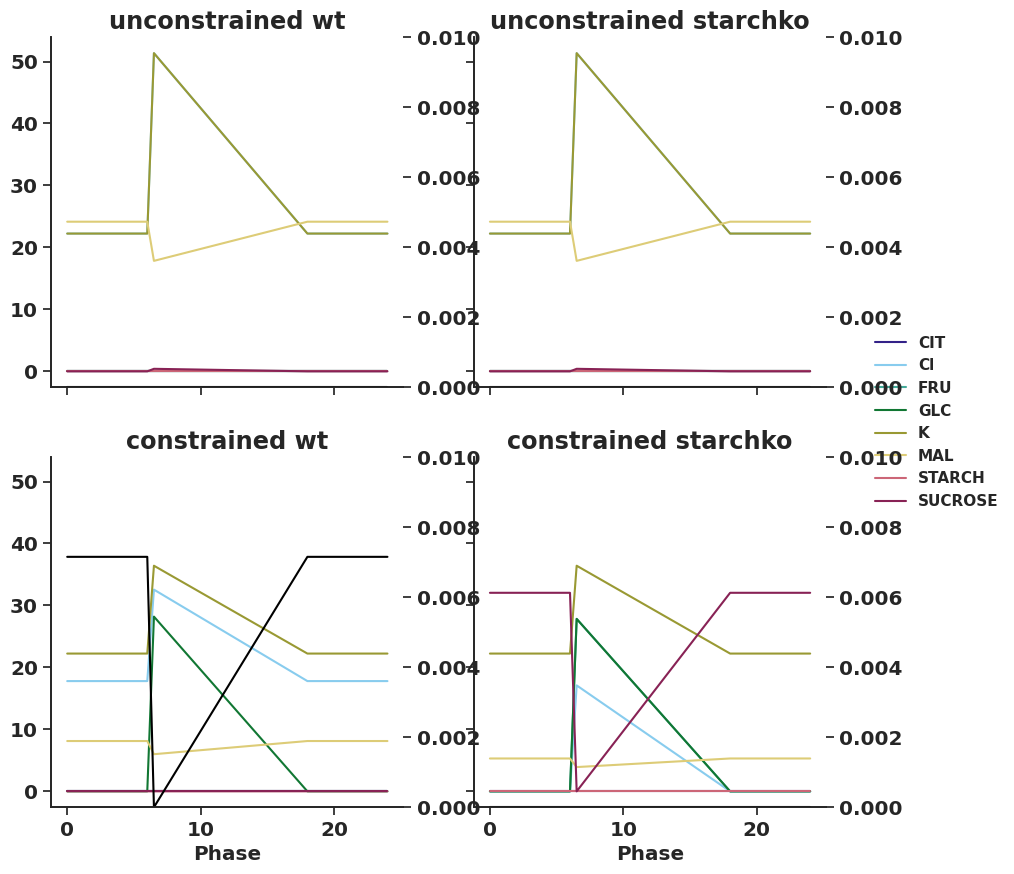

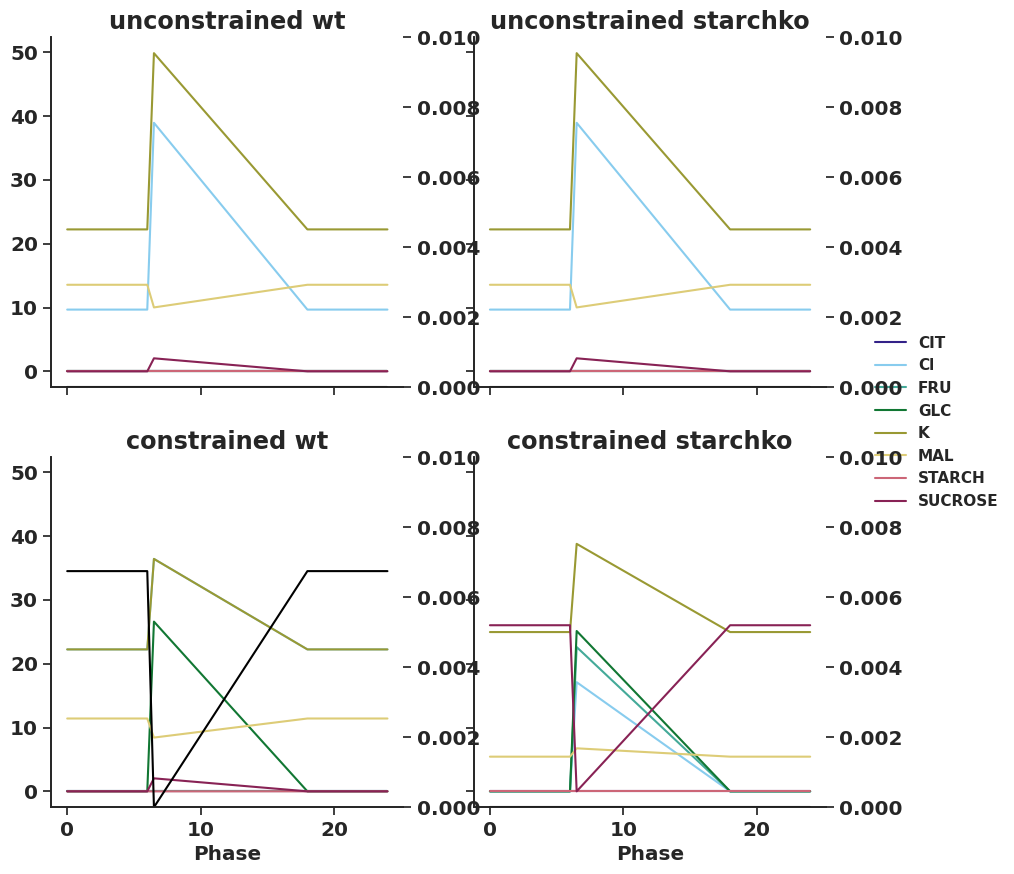

In [26]:
for light in ["blue", "white"]:
    plot_linkers(met_df_mm, light)

## Plotting before and after opening

In [27]:
def convert_starch_cols_to_per_gc(row_series, SuperModel, units):
    if row_series.name[1] == "STARCH":
        n_gcs = SuperModel.N_gcs
        row_series_moles = row_series * 10**-3
        moles_per_gc = row_series_moles / n_gcs
        row_series_converted_to_units = moles_per_gc * (1 / units)

        return row_series_converted_to_units

    else:
        return row_series

In [28]:
femtomoles = 10**-15
met_df_mm_starch_fmol_per_gc = met_df_mm.apply(
    convert_starch_cols_to_per_gc, args=[arabidopsis_supermodel, femtomoles], axis=1
)

In [29]:
met_df_mm_starch_fmol_per_gc.xs("STARCH", level="Reaction").xs(
    "fluxes", level="Solution", axis=1
)

Light           blue                                       white           \
ATPase unconstrained          constrained          unconstrained            
Starch            wt starchko          wt starchko            wt starchko   
Phase                                                                       
0.0              0.0      0.0   12.335626      0.0           0.0      0.0   
6.0              0.0      0.0   12.335626      0.0           0.0      0.0   
6.5              0.0      0.0    0.000000      0.0           0.0      0.0   
18.0             0.0      0.0   12.335626      0.0           0.0      0.0   
24.0             0.0      0.0   12.335626      0.0           0.0      0.0   

Light                                nops                                
ATPase constrained          unconstrained          constrained           
Starch          wt starchko            wt starchko          wt starchko  
Phase                                                                    
0.0      11.632011      0.0           0.0      0.0    5.132157      0.0  
6.0      11.632011      0.0           0.0      0.0    5.132157      0.0  
6.5       0.000000      0.0           0.0      0.0    0.000000      0.0  
18.0     11.632011      0.0           0.0      0.0    5.132157      0.0  
24.0     11.632011      0.0           0.0      0.0    5.132157      0.0

/tmp/ipykernel_2392372/1926438676.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs(
/tmp/ipykernel_2392372/1926438676.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs(
/tmp/ipykernel_2392372/1926438676.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs(
/tmp/ipykernel_2392372/1926438676.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs(
/tmp/ipykernel_2392372/1926438676.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs(
/tmp/ipykernel_2392372/1926438676.py:3: PerformanceWarning: indexing past l

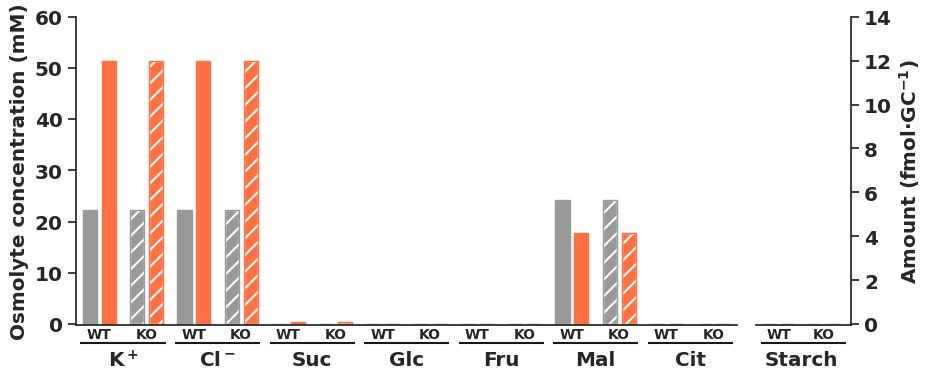

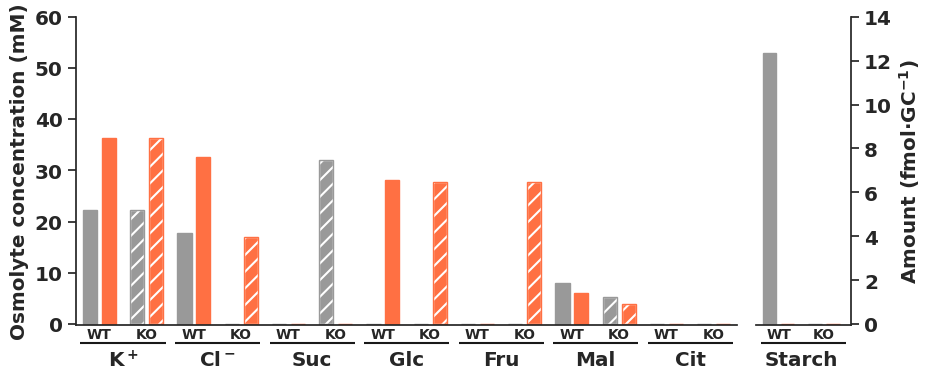

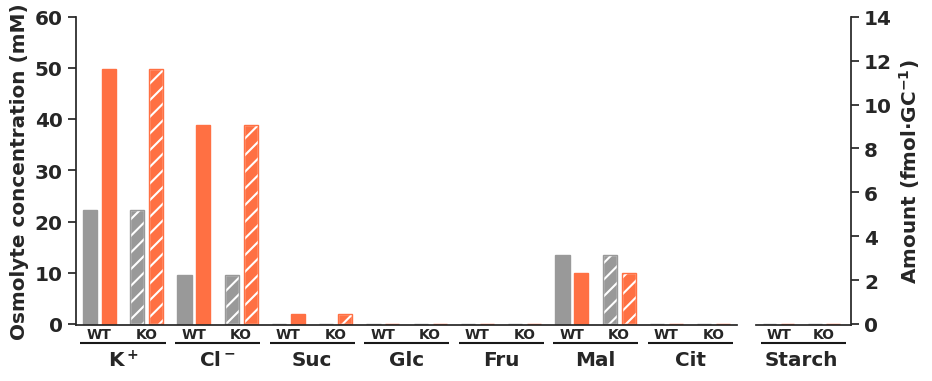

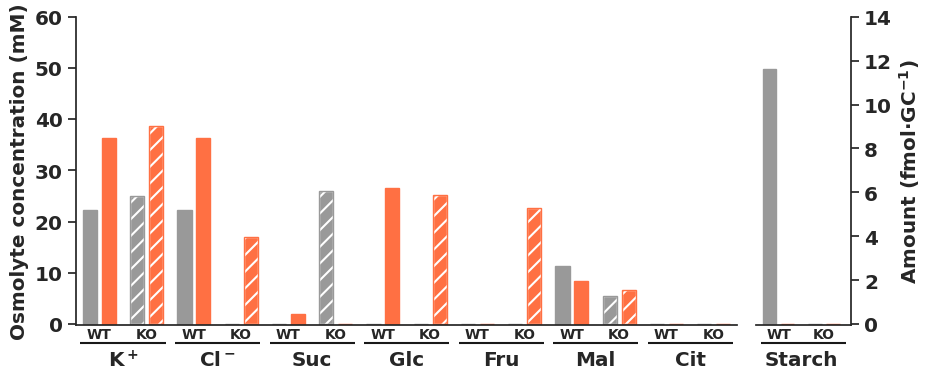

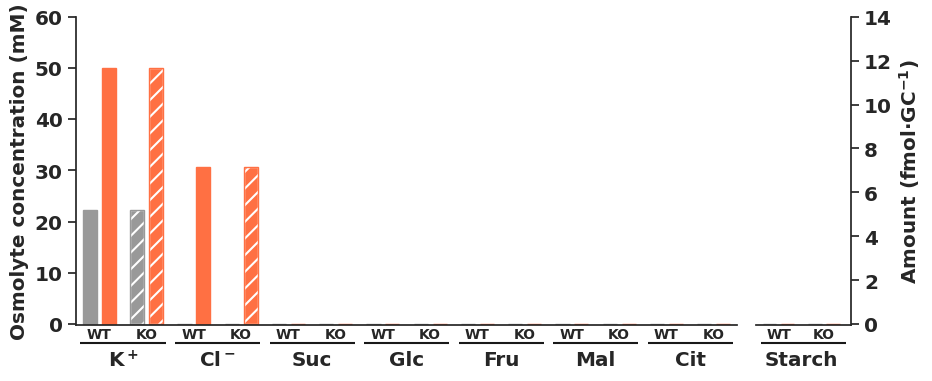

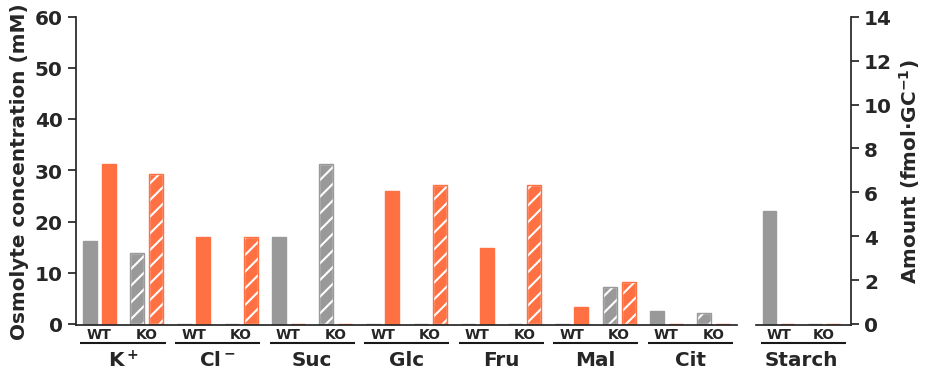

In [30]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        specific_df = met_df_mm_starch_fmol_per_gc.loc[:, (light, atpase)].xs(
            "fluxes", level="Solution", axis=1
        )
        fig = get_totals_plot(specific_df)
        plot_name = f"{light}_{atpase}"
        fig.savefig(
            f"../outputs/total_opening_plots/{plot_name}.svg",
            format="svg",
            bbox_inches="tight",
        )
        fig.savefig(
            f"../outputs/total_opening_plots/{plot_name}.png",
            format="png",
            bbox_inches="tight",
            dpi=300,
        )

## Flux maps

In [149]:
map_translation = {
    "": "Opening",
    "_1": "Night2",
    "_2": "Night1",
    "_3": "Day",
}

In [156]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        for starch in ["wt", "starchko"]:
            for map_suffix in ["", "_1", "_2", "_3"]:
                model_solution = solutions_df_unphased.loc[
                    :, (light, atpase, starch, "fluxes")
                ]
                flux_map = get_escher_map(
                    model_solution,
                    map=f"../inputs/map{map_suffix}.json",
                    json_model="../models/4_stage_GC.json",
                )
                flux_map_name = f"{light}_{atpase}_{starch}"
                flux_map.save_html(
                    f"../outputs/escher_maps/{flux_map_name}_{map_translation[map_suffix]}.html"
                )

In [32]:
linkers_met_dict = {
    "SUCROSE": "Suc",
    "GLC": "Glc",
    "FRU": "Fru",
    "MAL": "Mal",
    "CIT": "Cit",
    "L_ASPARTATE": "Asp",
    "SER": "Ser",
}

In [33]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("white", "constrained", "starchko", "fluxes"),
].unstack(0)

Phase                          6.0        6.5
Reaction    Compartment                      
SUCROSE     Cytoplasm     0.000000   0.000000
            Vacuole      34.645661   0.000000
GLC         Cytoplasm     0.000000  10.107359
            Vacuole       0.000000  30.092231
FRU         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000  30.092231
MAL         Cytoplasm    21.813541   0.000000
            Vacuole       0.000000   6.281906
CIT         Cytoplasm     0.000000   0.000000
            Vacuole       0.000000   0.000000
L_ASPARTATE Vacuole       3.099630   0.000000
SER         Vacuole       0.000000   2.692250

In [34]:
linkers_df.loc[
    ([6, 6.5], ["SUCROSE", "GLC", "FRU", "MAL", "CIT", "L_ASPARTATE", "SER"]),
    ("white", "constrained", "wt", "fluxes"),
].unstack(0)

Phase                          6.0         6.5
Reaction    Compartment                       
SUCROSE     Cytoplasm     0.000000    8.180265
            Vacuole       0.000000    0.000000
GLC         Cytoplasm     0.000000  106.776924
            Vacuole       0.000000    0.000000
FRU         Cytoplasm     0.000000    0.000000
            Vacuole       0.000000    0.000000
MAL         Cytoplasm     0.000000   33.828463
            Vacuole      10.634455    0.000000
CIT         Cytoplasm     0.000000    0.000000
            Vacuole       0.000000    0.000000
L_ASPARTATE Vacuole       0.000000    0.000000
SER         Vacuole       0.000000    0.000000

In [35]:
for light in ["blue", "white", "nops"]:
    for atpase in ["unconstrained", "constrained"]:
        for starch in ["wt", "starchko"]:
            print(f"{light}_{atpase}_{starch}")

            mets_to_include = [
                "SUCROSE",
                "GLC",
                "FRU",
                "MAL",
                "CIT",
                "L_ASPARTATE",
                "SER",
            ]
            test_df = linkers_df.loc[
                (
                    [6, 6.5],
                    mets_to_include,
                ),
                (light, atpase, starch, "fluxes"),
            ].unstack(0)
            test_df.columns = ["EoN", "30 mins"]
            test_df.index = pd.MultiIndex.from_tuples(
                [(linkers_met_dict[index[0]], index[1]) for index in test_df.index]
            )

            scaling = 0.4

            test_df = test_df * scaling

            if (test_df.loc[["Asp", "Ser"]] > 0.0000000001).sum().sum() > 0:
                aspser = True
                print(test_df)
            else:
                aspser = False

            scale_conc = 50  # mM

            scaled_scale_conc = scale_conc * scaling

            map_name = f"{light}_{atpase}_{starch}"
            if starch == "wt":
                gc_path = getgcdiagram(
                    test_df,
                    map_name,
                    atpase,
                    starch,
                    scaled_scale_conc,
                    flipped=False,
                    aspser=aspser,
                    display_svg=True,
                    debug=False,
                    brokenaxis=False,
                )
            else:
                gc_path = getgcdiagram(
                    test_df,
                    map_name,
                    atpase,
                    starch,
                    scaled_scale_conc,
                    flipped=True,
                    aspser=aspser,
                    display_svg=True,
                    debug=False,
                    brokenaxis=False,
                )

            # doesn't seem to work with hatched
            # svg_code = open(gc_path, 'rt').read()
            # svg2png(bytestring=svg_code, write_to=f"../outputs/flux_maps/{map_name}.png", dpi=300)

blue_unconstrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


blue_unconstrained_starchko
                     EoN    30 mins
Suc Cytoplasm   0.000000   0.656051
    Vacuole     0.000000   0.000000
Glc Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Mal Cytoplasm   0.000000  28.640165
    Vacuole     9.003441   0.000000
Cit Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole    18.352490  15.940448
Ser Vacuole     0.000000   0.000000
('Cit', 'Vacuole') not in template


blue_constrained_wt
                     EoN    30 mins
Suc Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Glc Cytoplasm   0.000000  45.294326
    Vacuole     0.000000   0.000000
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Mal Cytoplasm   0.000000   9.629600
    Vacuole     3.027201   0.000000
Cit Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole    29.878095  25.951260
Ser Vacuole     0.000000   0.000000
('Cit', 'Vacuole') not in template


blue_constrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_unconstrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_unconstrained_starchko
                     EoN    30 mins
Suc Cytoplasm   0.000000   3.277305
    Vacuole     0.000000   0.000000
Glc Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Mal Cytoplasm   0.000000  16.081843
    Vacuole     5.055555   0.000000
Cit Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole    25.966270  22.553560
Ser Vacuole     0.000000   0.000000
('Cit', 'Vacuole') not in template


white_constrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


white_constrained_starchko
                     EoN    30 mins
Suc Cytoplasm   0.000000   0.000000
    Vacuole    13.858264   0.000000
Glc Cytoplasm   0.000000   4.042944
    Vacuole     0.000000  12.036893
Fru Cytoplasm   0.000000   0.000000
    Vacuole     0.000000  12.036893
Mal Cytoplasm   8.725416   0.000000
    Vacuole     0.000000   2.512762
Cit Cytoplasm   0.000000   0.000000
    Vacuole     0.000000   0.000000
Asp Vacuole     1.239852   0.000000
Ser Vacuole     0.000000   1.076900
('Cit', 'Vacuole') not in template


nops_unconstrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_unconstrained_starchko
                     EoN   30 mins
Suc Cytoplasm   0.000000   0.00000
    Vacuole     0.000000   0.00000
Glc Cytoplasm   0.000000   0.00000
    Vacuole     0.000000   0.00000
Fru Cytoplasm   0.000000   0.00000
    Vacuole     0.000000   0.00000
Mal Cytoplasm   0.000000   0.00000
    Vacuole     0.000000   0.00000
Cit Cytoplasm   0.000000   0.00000
    Vacuole     0.000000   0.00000
Asp Vacuole    35.716268  31.02213
Ser Vacuole     0.000000   0.00000
('Cit', 'Vacuole') not in template


nops_constrained_wt
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


nops_constrained_starchko
('Asp', 'Vacuole') not in template
('Ser', 'Vacuole') not in template


In [36]:
blue_phloem_tx_overall_df = solutions_df.loc["Phloem_tx_overall", "blue"].xs(
    "fluxes", level="Solution", axis=1
)
white_phloem_tx_overall_df = solutions_df.loc["Phloem_tx_overall", "white"].xs(
    "fluxes", level="Solution", axis=1
)

In [37]:
blue_phloem_tx_overall_df_wt_unconstrained_corrected = (
    blue_phloem_tx_overall_df - blue_phloem_tx_overall_df.iloc[0, 0]
)
blue_phloem_tx_overall_df_wt_unconstrained_corrected = (
    blue_phloem_tx_overall_df_wt_unconstrained_corrected.mask(
        blue_phloem_tx_overall_df_wt_unconstrained_corrected > -0.0000000001, 0
    )
)
blue_phloem_tx_overall_df_wt_unconstrained_corrected_fmol = (
    blue_phloem_tx_overall_df_wt_unconstrained_corrected
    / parameters_df.loc["N_gcs", "Value"]
    * 10**12
)

In [38]:
white_phloem_tx_overall_df_wt_unconstrained_corrected = (
    white_phloem_tx_overall_df - white_phloem_tx_overall_df.iloc[0, 0]
)
white_phloem_tx_overall_df_wt_unconstrained_corrected = (
    white_phloem_tx_overall_df_wt_unconstrained_corrected.mask(
        white_phloem_tx_overall_df_wt_unconstrained_corrected > -0.0000000001, 0
    )
)
white_phloem_tx_overall_df_wt_unconstrained_corrected_fmol = (
    white_phloem_tx_overall_df_wt_unconstrained_corrected
    / parameters_df.loc["N_gcs", "Value"]
    * 10**12
)

In [39]:
combined_fmol = pd.concat(
    [
        blue_phloem_tx_overall_df_wt_unconstrained_corrected_fmol,
        white_phloem_tx_overall_df_wt_unconstrained_corrected_fmol,
    ],
    keys=["Blue", "White"],
)
combined_fmol.index = combined_fmol.index.droplevel(1)
combined_fmol

ATPase unconstrained          constrained          
Starch            wt starchko          wt  starchko
Blue             0.0      0.0   -0.009728 -0.030701
White            0.0      0.0   -0.011841 -0.037546

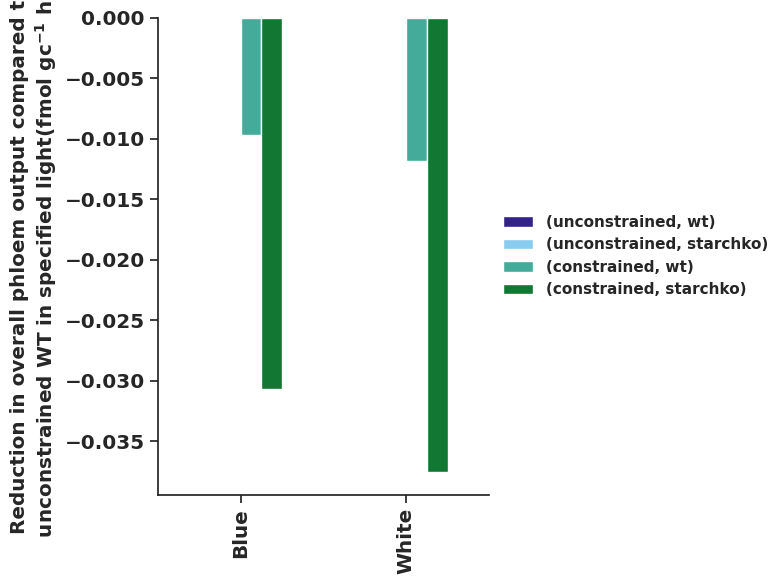

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
combined_fmol.plot.bar(ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_ylabel(
    "Reduction in overall phloem output compared to \n unconstrained WT in specified light(fmol gc$^{-1}$ h$^{-1}$)"
)

fig.set_tight_layout(True)

fig.savefig("../outputs/efficiency_comparisons/efficiency_comparisons_compared.svg")
fig.savefig("../outputs/efficiency_comparisons/efficiency_comparisons_compared.png")

In [41]:
from functools import reduce

In [42]:
def multiply_series_by_coefficient(series_object, model, metabolite_id):
    reaction_id = series_object.name[0]
    coefficient = model.reactions.get_by_id(f"{reaction_id}_1").get_coefficient(
        f"{metabolite_id}_1"
    )
    return coefficient * series_object

In [43]:
def get_metabolite_budget(solution_df, metabolite, model):
    metabolite_reactions_df = solution_df.loc[
        (
            [
                reaction.id[:-2]
                for reaction in four_stage_GC_model.metabolites.get_by_id(
                    f"{metabolite}_1"
                ).reactions
            ],
            slice(None),
        ),
        :,
    ]
    metabolite_consumed_produced_df = metabolite_reactions_df.apply(
        multiply_series_by_coefficient, args=[model, metabolite], axis=1
    )
    return metabolite_consumed_produced_df

In [44]:
def get_relevant_reaction_fluxes(
    solution_df,
    scenarios_to_drop=[("nops", "unconstrained"), ("white", "unconstrained")],
):
    solution_df = solution_df.xs("fluxes", level="Solution", axis=1)
    solution_df = solution_df.drop(
        scenarios_to_drop, axis=1
    )  # only keep the scenarios that we are interested in
    solution_df = solution_df.loc[
        (abs(solution_df) > 0.00001).any(axis=1), :
    ]  # pick only reactions which have a flux in at least one scenario
    solution_df[abs(solution_df) < 0.00001] = 0  # ignore tiny fluxes from solver error

    return solution_df

In [45]:
def get_budget_for_multiple_metabolites(solution_df, metabolites, fba_model):
    metabolite_dfs = [
        get_metabolite_budget(solution_df, metabolite, fba_model)
        for metabolite in metabolites
    ]
    metabolite_total_df = reduce(lambda a, b: a.add(b, fill_value=0), metabolite_dfs)
    metabolite_total_df = get_relevant_reaction_fluxes(metabolite_total_df)

    return metabolite_total_df

In [46]:
atp_metabolites = [
    metabolite.id
    for metabolite in four_stage_GC_model.metabolites
    if "ATP" in metabolite.id
]
gc_atp_metabolites = [
    metabolite[:-2] for metabolite in atp_metabolites if "gc_2" in metabolite
]
gc_atp_metabolites = [
    e
    for e in gc_atp_metabolites
    if e not in ("DATP_p_gc", "PHOSPHORIBOSYL_ATP_p_gc", "aDATP_p_gc")
]
atp_budget_df = get_budget_for_multiple_metabolites(
    solutions_df, gc_atp_metabolites, four_stage_GC_model
)

/tmp/ipykernel_2392372/4184850721.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(


In [47]:
nadh_nadph_metabolites = [
    metabolite.id
    for metabolite in four_stage_GC_model.metabolites
    if "NADH" in metabolite.id or "NADPH" in metabolite.id
]
gc_nadh_nadph_metabolites = [
    metabolite[:-2] for metabolite in nadh_nadph_metabolites if "gc_2" in metabolite
]
nadh_nadph_budget_df = get_budget_for_multiple_metabolites(
    solutions_df, gc_nadh_nadph_metabolites, four_stage_GC_model
)

/tmp/ipykernel_2392372/4184850721.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(


In [48]:
nadh_nadph_budget_df

Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000  0.000000   
                                       3          0.022910  0.022910   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2          0.000000  0.000000   
                                       3         -0.021569 -0.021569   
2OXOGLUTARATEDEH_RXN_m_gc              2          0.000768  0.000768   
                                       3          0.000000  0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 2         -0.000829 -0.000829   
                                       3          0.000000  0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000  0.000000   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3          0.000000  0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  2          0.000768  0.000768   
                                       3          0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    2          0.000000  0.000000   
                                       3         -0.001341 -0.001341   
MALATE_DEH_RXN_c_gc                    2          0.000829  0.000829   
                                       3          0.000000  0.000000   
MALATE_DEH_RXN_m_gc                    2          0.001535  0.001535   
                                       3          0.001272  0.001272   
MALATE_DEH_RXN_p_gc                    2          0.000000  0.000000   
                                       3          0.000000  0.000000   
MALATE_DEH_RXN_x_gc                    3          0.000000  0.000000   
NADH_DEHYDROG_A_RXN_mi_gc              2         -0.003838 -0.003838   
                                       3         -0.001272 -0.001272   
PGLYCDEHYDROG_RXN_p_gc                 2          0.000000  0.000000   
PYRUVDEH_RXN_m_gc                      2          0.000768  0.000768   
                                       3          0.000000  0.000000   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000  0.000000   
                                       3        0.022910  0.022910   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000  0.000000   
                                       3       -0.021534 -0.021405   
2OXOGLUTARATEDEH_RXN_m_gc              2        0.000537  0.000351   
                                       3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 2        0.000000  0.000000   
                                       3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000  0.000000   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3        0.000000  0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  2        0.000537  0.000351   
                                       3        0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    2        0.000000  0.000000   
                                       3       -0.001377 -0.001505   
MALATE_DEH_RXN_c_gc                    2        0.000000  0.000000   
                                       3        0.000000  0.000000   
MALATE_DEH_RXN_m_gc                    2        0.001074  0.000701   
                                       3        0.001353  0.001490   
MALATE_DEH_RXN_p_gc                    2        0.000000  0.000000   
                                       3        0.000000  0.000000   
MALATE_DEH_RXN_x_gc                    3        0.000000  0.000000   
NADH_DEHYDROG_A_RXN_mi_gc              2       -0.002684 -0.001753   
                   

In [49]:
atp_ordered_by_most_likely_importance = (
    abs(atp_budget_df)
    .groupby(by="Reaction")
    .sum()
    .sum(axis=1)
    .sort_values(ascending=False)
)
atp_budget_df_reordered = atp_budget_df.reindex(
    atp_ordered_by_most_likely_importance.index, level="Reaction"
)

In [50]:
nadh_nadph_ordered_by_most_likely_importance = (
    abs(nadh_nadph_budget_df)
    .groupby(by="Reaction")
    .sum()
    .sum(axis=1)
    .sort_values(ascending=False)
)
nadh_nadph_budget_df_reordered = nadh_nadph_budget_df.reindex(
    nadh_nadph_ordered_by_most_likely_importance.index, level="Reaction"
)

In [51]:
def convert_fluxes_to_per_guard_cell(series, super_model, units):
    return series * 10**-3 / super_model.N_gcs * (1 / units)

In [52]:
units = 10**-15  # fmol

In [53]:
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)

Carbon movement df generation

In [54]:
apoplastic_linker_reactions = [
    reaction.id[:-2]
    for reaction in four_stage_GC_model.reactions
    if "a_Linker" in reaction.id
]
get_relevant_reaction_fluxes(
    solutions_df.loc[(apoplastic_linker_reactions, slice(None)), :]
)

/tmp/ipykernel_2392372/4184850721.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(


Light                           blue                                  \
ATPase                 unconstrained           constrained             
Starch                            wt  starchko          wt  starchko   
Reaction         Phase                                                 
SUCROSE_a_Linker 3          0.010272  0.010272    0.006685  0.006689   

Light                        white                  nops           
ATPase                 constrained           constrained           
Starch                          wt  starchko          wt starchko  
Reaction         Phase                                             
SUCROSE_a_Linker 3        0.007382  0.007517         0.0      0.0

In [55]:
transfer_reactions = [
    reaction.id[:-2]
    for reaction in four_stage_GC_model.reactions
    if "ae_gc" in reaction.id
]
transfer_reactions = [
    e
    for e in transfer_reactions
    if e not in ("WATER_ae_gc", "K_ae_gc", "Cl_ae_gc", "NITRATE_ae_gc")
]
transfer_reactions = solutions_df.loc[(transfer_reactions, slice(None)), :]
transfer_reactions = get_relevant_reaction_fluxes(transfer_reactions)
transfer_reactions.loc[("GLC_ae_gc", 2), :] = 0
transfer_reactions

/tmp/ipykernel_2392372/4184850721.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(


Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_gc 3         -0.000893 -0.000893   -0.000581 -0.000582   -0.000642   
GLC_ae_gc     3          0.000000  0.000000   -0.000622 -0.000614   -0.000587   
              2          0.000000  0.000000    0.000000  0.000000    0.000000   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_gc 3     -0.000654    0.000305  0.000319  
GLC_ae_gc     3     -0.000554   -0.000574 -0.000599  
              2      0.000000    0.000000  0.000000

In [56]:
transfer_reactions_me = [
    reaction.id[:-2]
    for reaction in four_stage_GC_model.reactions
    if "ae_me" in reaction.id
]
transfer_reactions_me = [
    e
    for e in transfer_reactions_me
    if e
    not in (
        "WATER_ae_me",
        "K_ae_me",
        "Cl_ae_me",
        "NITRATE_ae_me",
        "SULFATE_ae_me",
        "AMMONIUM_ae_me",
    )
]
transfer_reactions_me = get_relevant_reaction_fluxes(
    solutions_df.loc[(transfer_reactions_me, slice(None)), :]
)
transfer_reactions_me

/tmp/ipykernel_2392372/4184850721.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  solution_df = solution_df.drop(


Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_me 3          0.000000  0.000000    0.000000  0.000000    0.000000   
              4          0.001712  0.001712    0.001114  0.001115    0.001230   
GLC_ae_me     3          0.000000  0.000000    0.000622  0.000614    0.000587   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_me 3      0.000000   -0.000305 -0.000319  
              4      0.001253    0.000000  0.000000  
GLC_ae_me     3      0.000554    0.000574  0.000599

In [57]:
def adjust_for_hexose_equivalents(series_object):
    hexose_equivalents = {
        "GLC": 1,
        "SUCROSE": 2,
        "FRU": 1,
    }

    metabolite = series_object.name[0].split("_")[0]
    hexose_equivalent = hexose_equivalents[metabolite]

    return series_object * hexose_equivalent

In [58]:
from mmon_gcm.analysing import adjust_for_phases

In [59]:
transfer_reactions_me

Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
SUCROSE_ae_me 3          0.000000  0.000000    0.000000  0.000000    0.000000   
              4          0.001712  0.001712    0.001114  0.001115    0.001230   
GLC_ae_me     3          0.000000  0.000000    0.000622  0.000614    0.000587   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
SUCROSE_ae_me 3      0.000000   -0.000305 -0.000319  
              4      0.001253    0.000000  0.000000  
GLC_ae_me     3      0.000554    0.000574  0.000599

In [60]:
me_carbon_production_consumption = (
    transfer_reactions_me.apply(adjust_for_phases, args=[four_stage_GC_model], axis=1)
    .apply(adjust_for_hexose_equivalents, axis=1)
    .sum()
    * -1
)
me_carbon_production_consumption

Light  ATPase         Starch  
blue   unconstrained  wt         -0.020545
                      starchko   -0.020545
       constrained    wt         -0.020525
                      starchko   -0.020440
white  constrained    wt         -0.021510
                      starchko   -0.021406
nops   constrained    wt          0.000405
                      starchko    0.000455
dtype: float64

In [61]:
gc_carbon_production_consumption = (
    transfer_reactions.loc[["GLC_ae_gc", "SUCROSE_ae_gc"], :]
    .apply(adjust_for_phases, args=[four_stage_GC_model], axis=1)
    .apply(adjust_for_hexose_equivalents, axis=1)
    * -1
)
gc_carbon_production_consumption

Light                        blue                                       white  \
ATPase              unconstrained           constrained           constrained   
Starch                         wt  starchko          wt  starchko          wt   
Reaction      Phase                                                             
GLC_ae_gc     3         -0.000000 -0.000000    0.007155  0.007062    0.006747   
              2         -0.000000 -0.000000   -0.000000 -0.000000   -0.000000   
SUCROSE_ae_gc 3          0.020545  0.020545    0.013370  0.013379    0.014764   

Light                                nops            
ATPase                        constrained            
Starch               starchko          wt  starchko  
Reaction      Phase                                  
GLC_ae_gc     3      0.006373    0.006605  0.006886  
              2     -0.000000   -0.000000 -0.000000  
SUCROSE_ae_gc 3      0.015033   -0.007010 -0.007341

In [62]:
gc_carbon_production_consumption_nmoles_gc = gc_carbon_production_consumption.apply(
    convert_fluxes_to_per_guard_cell, args=[arabidopsis_supermodel, units], axis=1
)

In [63]:
atp_colours = {
    "6PFRUCTPHOS_RXN_c_gc": [6, 6],  # phosphofructokinase glycolysis
    "FRUCTOKINASE_RXN_c_gc": [6, 6],  # fructokinase glycolysis
    "GLUC1PADENYLTRANS_RXN_p_gc": [8, 8],  # glc1p -> adp glc (starch synthesis)
    "GLY3KIN_RXN_p_gc": [6, 6],  # g3p -> glycerate (carbon degradation)
    "Mitochondrial_ATP_Synthase_m_gc": [7, 7],  # mitochondrial atp synthase
    "PEPCARBOXYKIN_RXN_c_gc": [6, 6],  # OAA -> pyruvate (mal deg)
    "PEPDEPHOS_RXN_c_gc": [6, 6],  # PEP -> pyruvate
    "PEPDEPHOS_RXN_p_gc": [6, 6],  # PEP -> pyruvate
    "PHOSGLYPHOS_RXN_c_gc": [2, 6],  # DPG -> G3p (glycolysis)
    "PHOSGLYPHOS_RXN_p_gc": [4, 4],  # DPG -> G3p (glycolysis)
    "PHOSPHORIBULOKINASE_RXN_p_gc": [4, 4],  # calvin cycle
    "PROTONATP_rev_vc_gc": [0, 0],  # tonoplastic proton pump
    "PROTON_ATPase_c_gc": [1, 1],  # plasma membrane proton pump
    "Plastidial_ATP_Synthase_p_gc": [3, 3],  # plastidial atp_synthase
    "SUCCCOASYN_RXN_m_gc": [6, 6],  # TCA cycle
    "UDPKIN_RXN_c_gc": [2, 2],  # atp->utp, sucrose synthesis
    "GLUCOKIN_RXN_c_gc": [9, 9],
    "ATP_ADP_mc_gc": [9, 9],  # ATP shuttle
}

nadh_nadph_colours = {
    "1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc": [3, 3],  # ps
    "1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc": [4, 4],  # ps
    "2OXOGLUTARATEDEH_RXN_m_gc": [6, 6],  # tca
    "GAPOXNPHOSPHN_RXN_c_gc": [2, 6],  # glycolysis or gluconeogenesis
    "GAPOXNPHOSPHN_RXN_p_gc": [4, 4],  # calvin cycle but nadh
    "HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc": [
        5,
        5,
    ],  # OH_PYR_x -> Glycerate_x to do with serine/aspartate metabolism
    "ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc": [6, 6],  # tca
    "MALATE_DEHYDROGENASE_NADPs_RXN_p_gc": [9, 9],  # shuttle
    "MALATE_DEH_RXN_c_gc": [
        9,
        6,
    ],  # malate degradation when forward but also shuttle in reverse
    "MALATE_DEH_RXN_m_gc": [9, 9],  # can be tca but mainly shuttle
    "MALATE_DEH_RXN_p_gc": [9, 9],  # shuttle
    "MALATE_DEH_RXN_x_gc": [9, 9],  # shuttle
    "MALIC_NAD_RXN_m_gc": [6, 6],  # malate degradation (al->pyr)
    "NADH_DEHYDROG_A_RXN_mi_gc": [7, 7],  # complex 1 (TC)
    "PGLYCDEHYDROG_RXN_p_gc": [5, 5],  # ser_synthesis from g3p
    "PYRUVDEH_RXN_m_gc": [6, 6],  # pyruvate degradation
    "ISOCITDEH_RXN_c_gc": [6, 6],  # tca nadp
    "6PGLUCONDEHYDROG_RXN_p_gc": [9, 9],  # PPP
}

reaction_colours = {**atp_colours, **nadh_nadph_colours}
for reaction, colour_number in reaction_colours.items():
    for i, reverse_forward in enumerate(colour_number):
        if reverse_forward == 9:
            reaction_colours[reaction][i] = "#DDDDDD"
        else:
            reaction_colours[reaction][i] = colours[reverse_forward]

In [64]:
colours_legend = {
    "Tonoplast membrane ATPase": 0,
    "Plasma membrane ATPase": 1,
    "Sucrose/Glucose synthesis": 2,
    "Plastid/PS": 3,
    "Carbon fixation": 4,
    "Serine Synthesis": 5,
    "Carbon degradation\n(Glycolysis, TCA etc.)": 6,
    "ETC/Mitochondrial\nATP Synthase": 7,
    "Starch synthesis": 8,
    "Other e.g. shuttles": 9,
}
for category, colour_number in colours_legend.items():
    if colour_number == 9:
        colours_legend[category] = "#DDDDDD"
    else:
        colours_legend[category] = colours[colour_number]

In [65]:
carbon_colours = {
    "SUCROSE_ae_gc": colours[2],
    "GLC_ae_gc": colours[6],
    "FRU_ae_gc": colours[4],
}

In [66]:
legend_colours = {
    "Glucose": colours[6],
    "Sucrose": colours[2],
}

In [67]:
nadh_nadph_budget_df_reordered_nmoles_gc

Light                                                 blue             \
ATPase                                       unconstrained              
Starch                                                  wt   starchko   
Reaction                               Phase                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2          0.000000   0.000000   
                                       3         39.500551  39.500551   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2          0.000000   0.000000   
                                       3        -37.187689 -37.187689   
NADH_DEHYDROG_A_RXN_mi_gc              2         -6.617798  -6.617795   
                                       3         -2.193169  -2.193169   
MALATE_DEH_RXN_m_gc                    2          2.647119   2.647118   
                                       3          2.193169   2.193169   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    2          0.000000   0.000000   
                                       3         -2.312862  -2.312862   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  2          1.323560   1.323559   
                                       3          0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              2          1.323560   1.323559   
                                       3          0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      2          1.323560   1.323559   
                                       3          0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 2         -1.429384  -1.429372   
                                       3          0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    2          1.429384   1.429372   
                                       3          0.000000   0.000000   
MALATE_DEH_RXN_p_gc                    2          0.000000   0.000000   
                                       3          0.000000   0.000000   
PGLYCDEHYDROG_RXN_p_gc                 2          0.000000   0.000000   
MALATE_DEH_RXN_x_gc                    3          0.000000   0.000000   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3          0.000000   0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000   0.000000   

Light                                                                \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 2        0.000000   0.000000   
                                       3       39.500551  39.500551   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 2        0.000000   0.000000   
                                       3      -37.127180 -36.905720   
NADH_DEHYDROG_A_RXN_mi_gc              2       -4.628047  -3.023239   
                                       3       -2.333127  -2.568542   
MALATE_DEH_RXN_m_gc                    2        1.851219   1.209295   
                                       3        2.333127   2.568542   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    2        0.000000   0.000000   
                                       3       -2.373371  -2.594831   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  2        0.925609   0.604648   
                                       3        0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              2        0.925609   0.604648   
                                       3        0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      2        0.925609   0.604648   
                                       3        0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 2        0.000000   0.000000   
                                       3        0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    2        0.000000   0.000000   
                                       3        0.000000   0.000000   
MALATE_DEH_RXN_p_gc                    2        0.000000   0.000000   
                                  

In [68]:
color_order = [
    [nadh_nadph_colours[reaction][1], reaction]
    for reaction in nadh_nadph_budget_df_reordered_nmoles_gc.index.levels[0]
]
nadh_nadph_budget_df_reordered_nmoles_gc = nadh_nadph_budget_df_reordered_nmoles_gc.loc[
    pd.DataFrame(color_order).sort_values(by=[0, 1]).loc[:, 1].values
]

In [69]:
color_order = [
    [atp_colours[reaction][1], reaction]
    for reaction in atp_budget_df_reordered_nmoles_gc.index.levels[0]
]
atp_budget_df_reordered_nmoles_gc = atp_budget_df_reordered_nmoles_gc.loc[
    pd.DataFrame(color_order).sort_values(by=[0, 1]).loc[:, 1].values
]

In [70]:
atp_budget_df_reordered_nmoles_gc.drop("nops", axis=1).loc[
    ("Plastidial_ATP_Synthase_p_gc", 3)
].mean()

/tmp/ipykernel_2392372/2071576024.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  atp_budget_df_reordered_nmoles_gc.drop("nops", axis=1).loc[


50.78642316655137

In [71]:
(abs(nadh_nadph_budget_df_reordered_nmoles_gc) / 2).sum()

Light  ATPase         Starch  
blue   unconstrained  wt          49.740903
                      starchko    49.740888
       constrained    wt          46.461726
                      starchko    45.092332
white  constrained    wt          85.852878
                      starchko    87.598368
nops   constrained    wt           5.366958
                      starchko     3.997019
dtype: float64

In [72]:
nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), :]

Light                                                 blue             \
ATPase                                       unconstrained              
Starch                                                  wt   starchko   
Reaction                               Phase                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3         39.500551  39.500551   
NADH_DEHYDROG_A_RXN_mi_gc              3         -2.193169  -2.193169   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        -37.187689 -37.187689   
GAPOXNPHOSPHN_RXN_p_gc                 3          0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3          0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3          0.000000   0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3          0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    3          0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      3          0.000000   0.000000   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3          0.000000   0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3         -2.312862  -2.312862   
MALATE_DEH_RXN_m_gc                    3          2.193169   2.193169   
MALATE_DEH_RXN_p_gc                    3          0.000000   0.000000   
MALATE_DEH_RXN_x_gc                    3          0.000000   0.000000   

Light                                                                \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3       39.500551  39.500551   
NADH_DEHYDROG_A_RXN_mi_gc              3       -2.333127  -2.568542   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3      -37.127180 -36.905720   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.000000   0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3        0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    3        0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      3        0.000000   0.000000   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3        0.000000   0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3       -2.373371  -2.594831   
MALATE_DEH_RXN_m_gc                    3        2.333127   2.568542   
MALATE_DEH_RXN_p_gc                    3        0.000000   0.000000   
MALATE_DEH_RXN_x_gc                    3        0.000000   0.000000   

Light                                              white             \
ATPase                                       constrained              
Starch                                                wt   starchko   
Reaction                               Phase                          
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3       39.500551  39.500551   
NADH_DEHYDROG_A_RXN_mi_gc              3       -2.321904  -2.522065   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3      -37.122098 -36.978487   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.000000   0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.000000   0.000000   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.000000   0.000000   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3        0.000000   0.000000   
MALATE_DEH_RXN_c_gc                    3        0.000000   0.000000   
PYRUVDEH_RXN_m_gc                      3        0.000000   0.000000   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3        0.000000  -0.076919   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3       -2.378454  -2.522065   
MALATE_DEH_RXN_m_gc                    3        2.321904   2.522065   
MALATE_DEH_RXN_p_gc                    3        0.000000   0.000000   
MALATE_DEH_RXN_x_gc                    3        0.000000   0.076919   

Light                                               nops            
ATPase                                       constrained  

In [73]:
nops_nadph_3 = nadh_nadph_budget_df_reordered_nmoles_gc.loc[
    (slice(None), 3), "nops"
].index

In [74]:
colours_legend_iv = {v: k for k, v in colours_legend.items()}

In [75]:
nops_nadph_3_df = nadh_nadph_budget_df_reordered_nmoles_gc.loc[(slice(None), 3), "nops"]

In [76]:
nops_nadph_3

MultiIndex([('1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc', 3),
            (             'NADH_DEHYDROG_A_RXN_mi_gc', 3),
            ('1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc', 3),
            (                'GAPOXNPHOSPHN_RXN_p_gc', 3),
            (             '2OXOGLUTARATEDEH_RXN_m_gc', 3),
            (                'GAPOXNPHOSPHN_RXN_c_gc', 3),
            ( 'ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc', 3),
            (                   'MALATE_DEH_RXN_c_gc', 3),
            (                     'PYRUVDEH_RXN_m_gc', 3),
            ('HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc', 3),
            (   'MALATE_DEHYDROGENASE_NADPs_RXN_p_gc', 3),
            (                   'MALATE_DEH_RXN_m_gc', 3),
            (                   'MALATE_DEH_RXN_p_gc', 3),
            (                   'MALATE_DEH_RXN_x_gc', 3)],
           names=['Reaction', 'Phase'])

In [77]:
nops_nadph_3_reactions = [i[0] for i in nops_nadph_3]

In [78]:
descriptions = []
for reaction in nops_nadph_3_reactions:
    descriptions.append(
        colours_legend_iv[nadh_nadph_colours[reaction][0]].replace("\n", "")
    )

In [79]:
nops_nadph_3_df.loc[:, "Description"] = descriptions

In [80]:
nops_nadph_3_df

ATPase                                       constrained            \
Starch                                                wt  starchko   
Reaction                               Phase                         
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.000000  0.000000   
NADH_DEHYDROG_A_RXN_mi_gc              3       -0.438120 -0.537478   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.000000  0.000000   
GAPOXNPHOSPHN_RXN_p_gc                 3        0.039595  0.000000   
2OXOGLUTARATEDEH_RXN_m_gc              3        0.037019  0.064150   
GAPOXNPHOSPHN_RXN_c_gc                 3        0.039595  0.136392   
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3        0.037019  0.064150   
MALATE_DEH_RXN_c_gc                    3       -0.039595 -0.136392   
PYRUVDEH_RXN_m_gc                      3        0.121361  0.136392   
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3        0.000000  0.000000   
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.000000  0.000000   
MALATE_DEH_RXN_m_gc                    3        0.242721  0.272785   
MALATE_DEH_RXN_p_gc                    3       -0.039595  0.000000   
MALATE_DEH_RXN_x_gc                    3        0.000000  0.000000   

ATPase                                                                     Description  
Starch                                                                                  
Reaction                               Phase                                            
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3                                    Plastid/PS  
NADH_DEHYDROG_A_RXN_mi_gc              3                 ETC/MitochondrialATP Synthase  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3                               Carbon fixation  
GAPOXNPHOSPHN_RXN_p_gc                 3                               Carbon fixation  
2OXOGLUTARATEDEH_RXN_m_gc              3      Carbon degradation(Glycolysis, TCA etc.)  
GAPOXNPHOSPHN_RXN_c_gc                 3                     Sucrose/Glucose synthesis  
ISOCITRATE_DEHYDROGENASE_NAD_RXN_m_gc  3      Carbon degradation(Glycolysis, TCA etc.)  
MALATE_DEH_RXN_c_gc                    3                           Other e.g. shuttles  
PYRUVDEH_RXN_m_gc                      3      Carbon degradation(Glycolysis, TCA etc.)  
HYDROXYPYRUVATE_REDUCTASE_RXN_NAD_x_gc 3                              Serine Synthesis  
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3                           Other e.g. shuttles  
MALATE_DEH_RXN_m_gc                    3                           Other e.g. shuttles  
MALATE_DEH_RXN_p_gc                    3                           Other e.g. shuttles  
MALATE_DEH_RXN_x_gc                    3                           Other e.g. shuttles

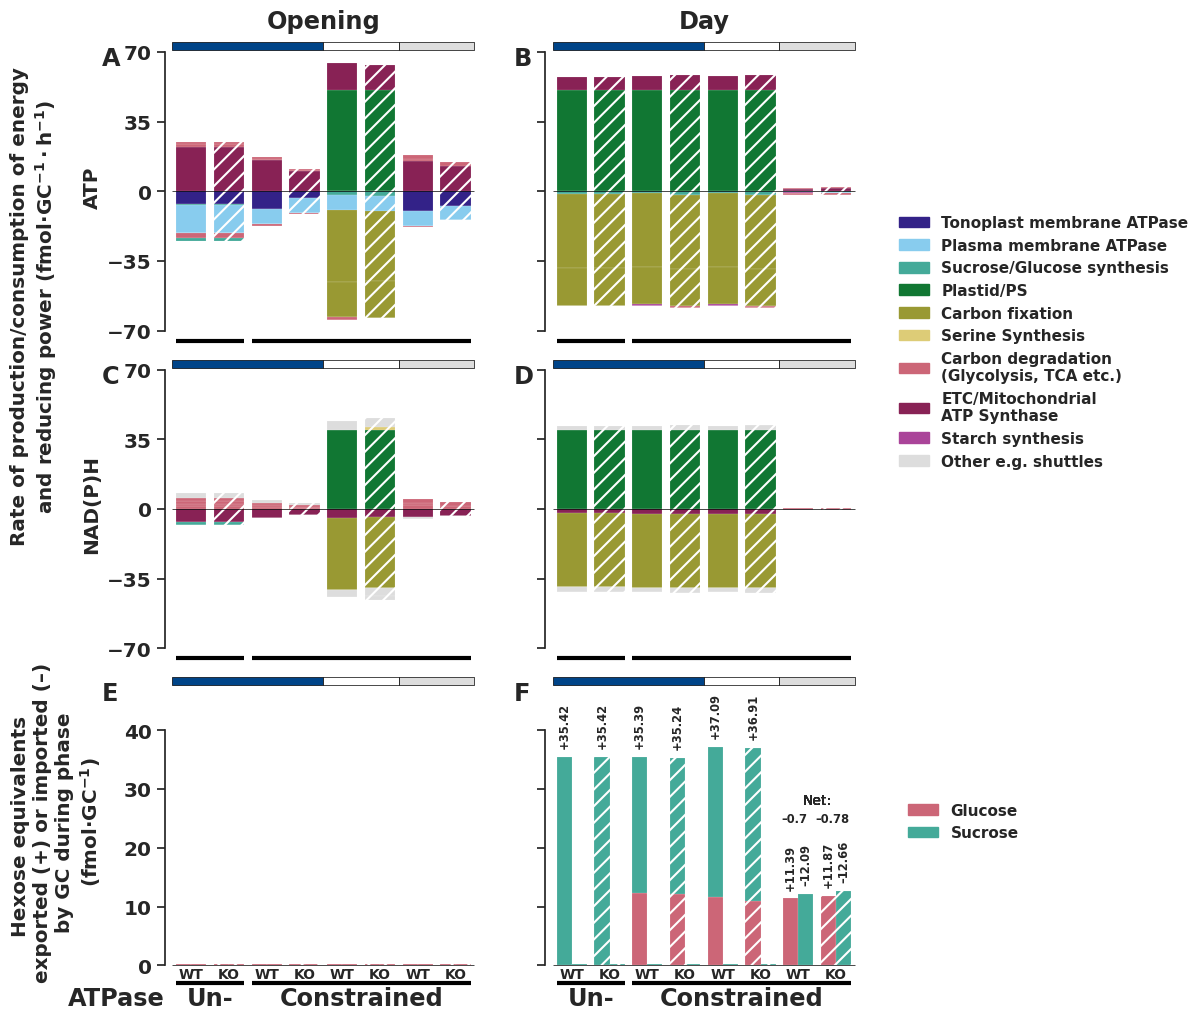

In [81]:
metabolites = ["ATP", "NAD(P)H"]
phases = ["Opening", "Day"]
hatches = {"wt": None, "starchko": "//"}
atpase_labelling = {"unconstrained": "–", "constrained": "+"}

fig, axs = plt.subplots(3, 2, figsize=(9, 12), sharex=True, sharey="row")
plt.subplots_adjust(hspace=0.1)

colour_rectangles_thickness = 4 / (75 * 2)

for y, metabolite in enumerate(
    [atp_budget_df_reordered_nmoles_gc, nadh_nadph_budget_df_reordered_nmoles_gc]
):
    for x, phase in enumerate([2, 3]):
        budget_df = metabolite.xs(phase, level="Phase")
        ax = axs[y][x]

        # if y == 0:
        for x1, x2, colour in zip(
            [-0.5, 3.5, 5.5], [3.5, 5.5, 7.5], ["#004488", "white", "#DDDDDD"]
        ):
            ax.fill_betweenx(
                [75 - colour_rectangles_thickness * 75 * 2, 75],
                x1,
                x2,
                alpha=1,
                color=colour,
                linewidth=0.5,
                edgecolor="black",
            )

        for i, scenario in enumerate(budget_df.columns):
            positive_bottom = 0
            negative_top = 0
            scenario_df = budget_df.loc[:, scenario]
            for reaction in scenario_df.index:
                value = scenario_df.loc[reaction]
                if value > 0.00001:
                    ax.bar(
                        i,
                        value,
                        bottom=positive_bottom,
                        color=reaction_colours[reaction][1],
                        linewidth=0.1,
                        hatch=hatches[scenario[2]],
                    )
                    positive_bottom += value
                elif value < 0.00001:
                    ax.bar(
                        i,
                        value,
                        bottom=negative_top,
                        color=reaction_colours[reaction][0],
                        linewidth=0.1,
                        hatch=hatches[scenario[2]],
                    )
                    negative_top += value

        # ax.text(i, positive_bottom + 0.005, round(positive_bottom, 6), rotation=90)
        ax.set_xticks([])  # range(len(budget_df.columns)))
        ax.set_xticklabels(
            []
        )  # [atpase_labelling[scenario[1]] for scenario in budget_df.columns])

        # if y==1:
        for x1, x2 in zip([-0.4, 1.6], [1.4, 7.4]):  # lines above atpase text
            ax.hlines(-75, x1, x2, color="black", linewidth=3, clip_on=False)

        """    
        atpase_text_y = -80
        if y==1:
            ax.text(0.5, atpase_text_y, "Un-", ha="center", va="top", size="x-large")
            ax.text(4.5, atpase_text_y, "Constrained", ha="center", va="top", size="x-large")
            if x == 0:
                ax.text(-0.7, atpase_text_y, "ATPase", ha="right", va="top", size="x-large")
        """

        if y == 0:
            ax.set_title(phases[x], pad=10)
        if x == 0:
            ax.set_ylabel(metabolites[y])

        ax.set_xlim(-0.70, 7.7)
        ax.set_ylim(-70, 75)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_bounds(-70, 70)
        # ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(35))
        # ax.yaxis.set_minor_locator(AutoMinorLocator(2))

        ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

fig.text(
    -0.02,
    0.66,
    r"Rate of production/consumption of energy"
    "\n"
    "and reducing power (fmol$\cdot$GC$^{-1}\cdot$h$^{-1}$)",
    rotation=90,
    va="center",
    ha="center",
    size="large",
)
# ax.set_title(f"ATP Phase {phase}", pad=70)

patchList = []
for key in colours_legend:
    data_key = mpatches.Patch(color=colours_legend[key], label=key)
    patchList.append(data_key)

fig.legend(handles=patchList, loc="center left", bbox_to_anchor=(0.925, 0.63))


for x, ax in enumerate(axs[2]):
    phase = [2, 3][x]

    y_lim_for_hexose = 49

    for x1, x2, colour in zip(
        [-0.5, 3.5, 5.5], [3.5, 5.5, 7.5], ["#004488", "white", "#DDDDDD"]
    ):
        ax.fill_betweenx(
            [
                y_lim_for_hexose - y_lim_for_hexose * colour_rectangles_thickness,
                y_lim_for_hexose,
            ],
            x1,
            x2,
            alpha=1,
            color=colour,
            linewidth=0.5,
            edgecolor="black",
        )

    for i, scenario in enumerate(gc_carbon_production_consumption_nmoles_gc.columns):
        positive_bottom = 0
        negative_top = 0
        scenario_df = gc_carbon_production_consumption_nmoles_gc.xs(
            phase, level="Phase"
        ).loc[:, scenario]
        for reaction in scenario_df.index:
            value = scenario_df.loc[reaction]
            if value > 0.00001:
                ax.bar(
                    i,
                    value,
                    bottom=positive_bottom,
                    color=carbon_colours[reaction],
                    linewidth=0.1,
                    hatch=hatches[scenario[2]],
                    align="edge",
                    width=-0.4,
                )
                positive_bottom += value
            elif value < 0.00001:
                ax.bar(
                    i,
                    abs(value),
                    bottom=negative_top,
                    color=carbon_colours[reaction],
                    linewidth=0.1,
                    hatch=hatches[scenario[2]],
                    align="edge",
                    width=0.4,
                )
                negative_top += abs(value)
        if positive_bottom == 0:
            ax.bar(
                i,
                0.3,
                bottom=0,
                color=carbon_colours[reaction],
                linewidth=0.1,
                hatch=hatches[scenario[2]],
                align="edge",
                width=-0.4,
            )
        if negative_top == 0:
            ax.bar(
                i,
                0.3,
                bottom=0,
                color=carbon_colours[reaction],
                linewidth=0.1,
                hatch=hatches[scenario[2]],
                align="edge",
                width=0.4,
            )

        # ax.text(
        #    i - 0.2, positive_bottom + 1.5, "+", ha="center", va="center", size="large"
        # )
        if positive_bottom > 0:
            ax.text(
                i - 0.2,
                positive_bottom + 1.5,
                f"+{round(positive_bottom, 2)}",
                ha="center",
                va="bottom",
                size="x-small",
                rotation=90,
            )
        # ax.text(i + 0.2, negative_top + 1.5, "-", ha="center", va="center", size="large")
        if negative_top > 0:
            ax.text(
                i + 0.2,
                negative_top + 1.5,
                f"–{abs(round(negative_top, 2))}",
                ha="center",
                va="bottom",
                size="x-small",
                rotation=90,
            )
        if positive_bottom > 0 and negative_top > 0:
            net_value = round(positive_bottom - negative_top, 2)
            if net_value < 0:
                ax.text(
                    i - 0.1,
                    25,
                    f"–{abs(net_value)}",
                    ha="center",
                    va="center",
                    size="x-small",
                )
            else:
                ax.text(
                    i - 0.1,
                    25,
                    f"{net_value}",
                    ha="center",
                    va="center",
                    size="x-small",
                )
        if phase == 3:
            ax.text(
                6.5, 27, "Net:", ha="center", va="bottom", size="small", weight="normal"
            )

        starch_condition = {"wt": "WT", "starchko": "KO"}[scenario_df.name[2]]
        ax.text(i, -1.5, starch_condition, ha="center", va="center", size="small")

    # ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

    patchList = []
    for key in legend_colours:
        data_key = mpatches.Patch(color=legend_colours[key], label=key)
        patchList.append(data_key)

    if x == 1:
        ax.legend(handles=patchList, loc="center left", bbox_to_anchor=(1.1, 0.5))

    for x1, x2 in zip([-0.4, 1.6], [1.4, 7.4]):  # lines above atpase text
        ax.hlines(-3, x1, x2, color="black", linewidth=3, clip_on=False)

    atpase_text_y = -3.5
    ax.text(0.5, atpase_text_y, "Un-", ha="center", va="top", size="x-large")
    ax.text(4.5, atpase_text_y, "Constrained", ha="center", va="top", size="x-large")
    if x == 0:
        ax.text(-0.7, atpase_text_y, "ATPase", ha="right", va="top", size="x-large")

    ax.set_xlim(-0.7, 7.7)
    ax.set_ylim(-0.1, y_lim_for_hexose)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_bounds(0, 40)
    ax.set_xticks([])  # range(len(budget_df.columns)))
    ax.set_xticklabels(
        []
    )  # [atpase_labelling[scenario[1]] for scenario in budget_df.columns])

    ax.hlines(0, -0.5, 7.5, color="black", linewidth=0.5)

    if x == 0:
        ax.set_ylabel(
            "Hexose equivalents \n exported (+) or imported (–) \n by GC during phase \n"
            r"(fmol$\cdot$GC$^{-1}$)",
            labelpad=15,
        )

i = 0
for y in range(3):
    for x in range(2):
        ax = axs[y][x]
        letter = string.ascii_uppercase[i]
        if x == 0:
            ax.text(-0.2, 0.92, letter, size="x-large", transform=ax.transAxes)
        elif x == 1:
            ax.text(-0.1, 0.92, letter, size="x-large", transform=ax.transAxes)
        i += 1


# fig.text(-0.02,0.25, "Hexose equivalents imported (+) \n or exported (-) by GC " r"(nmoles$\cdot$GC$^{-1}$)", rotation=90, va="center", ha="center", size="large")

fig.savefig(f"../plant_cell_paper/figure_6.svg", bbox_inches="tight")
fig.savefig(f"../plant_cell_paper/figure_6.png", dpi=300, bbox_inches="tight")

In [82]:
carbon_rank = gc_carbon_production_consumption_nmoles_gc.sum().rank(ascending=False)

In [83]:
atp_2_rank = (
    abs(atp_budget_df_reordered_nmoles_gc)
    .xs(2, level="Phase")
    .sum()
    .rank(ascending=False)
)
atp_3_rank = (
    abs(atp_budget_df_reordered_nmoles_gc)
    .xs(3, level="Phase")
    .sum()
    .rank(ascending=False)
)
atp_rank = (
    (
        abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 0.5
        + abs(atp_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 11.5
    )
    .sum()
    .rank(ascending=False)
)

In [84]:
nad_2_rank = (
    abs(nadh_nadph_budget_df_reordered_nmoles_gc)
    .xs(2, level="Phase")
    .sum()
    .rank(ascending=False)
)
nad_3_rank = (
    abs(nadh_nadph_budget_df_reordered_nmoles_gc)
    .xs(3, level="Phase")
    .sum()
    .rank(ascending=False)
)
nad_rank = (
    (
        abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 0.5
        + abs(nadh_nadph_budget_df_reordered_nmoles_gc).xs(3, level="Phase") * 11.5
    )
    .sum()
    .rank(ascending=False)
)

In [85]:
pd.concat(
    [carbon_rank, atp_2_rank, atp_3_rank, atp_rank, nad_2_rank, nad_3_rank, nad_rank],
    axis=1,
    keys=["Carbon", "ATP 2", "ATP 3", "ATP Day", "NAD 2", "NAD 3", "NAD Day"],
).sort_values("Carbon")

Carbon  ATP 2  ATP 3  ATP Day  NAD 2  NAD 3  \
Light ATPase        Starch                                                  
white constrained   wt           1.0    1.0    4.0      4.0    2.0    4.0   
                    starchko     2.0    2.0    2.0      2.0    1.0    1.0   
blue  unconstrained wt           3.0    3.0    6.0      6.0    3.0    6.0   
                    starchko     4.0    4.0    5.0      5.0    4.0    5.0   
      constrained   wt           5.0    6.0    3.0      3.0    6.0    3.0   
                    starchko     6.0    8.0    1.0      1.0    8.0    2.0   
nops  constrained   wt           7.0    5.0    8.0      8.0    5.0    8.0   
                    starchko     8.0    7.0    7.0      7.0    7.0    7.0   

                              NAD Day  
Light ATPase        Starch             
white constrained   wt            4.0  
                    starchko      1.0  
blue  unconstrained wt            6.0  
                    starchko      5.0  
      constrained   wt            3.0  
                    starchko      2.0  
nops  constrained   wt            8.0  
                    starchko      7.0

- Starch KO leads to lower carbon consumption and higher ATP and NAD turnover
- Constraining ATPase leads to lower efficiency and higher ATP and NAD turnover
- PS is more complicated because it's both phases, so won't include
    - Removing it vs blue eads to 

## Bits and bobs for paper

In [86]:
blue_constrained_wt_osmolytes = met_df_mm.loc[
    :, ("blue", "constrained", "wt", "fluxes")
].unstack()
os_fraction = (
    (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0])
    / (
        blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]
    ).sum()
    * 100
)
os_fraction

Reaction
CIT         0.000000
Cl         26.835378
FRU         0.000000
GLC        51.267357
K          25.774018
MAL        -3.863744
STARCH     -0.013009
SUCROSE     0.000000
dtype: float64

In [87]:
blue_constrained_wt_osmolytes

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
0.0,0.0,17.792024,0.0,0.000000,22.233377,8.119385,0.007155,0.0
6.0,0.0,17.792024,0.0,0.000000,22.233377,8.119385,0.007155,0.0
6.5,0.0,32.550786,0.0,28.195718,36.408419,5.994426,0.000000,0.0
18.0,0.0,17.792024,0.0,0.000000,22.233377,8.119385,0.007155,0.0
24.0,0.0,17.792024,0.0,0.000000,22.233377,8.119385,0.007155,0.0


In [88]:
os_fraction.loc["Cl"] + os_fraction.loc["K"]

52.609396203863554

In [89]:
(blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]).loc[
    "Cl"
] + (
    blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]
).loc[
    "K"
]

28.933804484359516

In [90]:
solutions_df

Light                                 blue                                     \
ATPase                       unconstrained                                      
Starch                                  wt                   starchko           
Solution                            fluxes minimum   maximum   fluxes minimum   
Reaction               Phase                                                    
EX_X_pi_t_me           1            0.0000     NaN       NaN   0.0000     NaN   
                       2            0.0000     NaN       NaN   0.0000     NaN   
                       3            0.0000     NaN       NaN   0.0000     NaN   
                       4            0.0000     NaN       NaN   0.0000     NaN   
EX_X_pi_t_gc           1            0.0000     NaN       NaN   0.0000     NaN   
...                                    ...     ...       ...      ...     ...   
Cl_total_pseudolinker  4            0.0049     NaN       NaN   0.0049     NaN   
CIT_total_pseudolinker 1            0.0000     0.0  0.010896   0.0000     0.0   
                       2            0.0000     0.0  0.011386   0.0000     0.0   
                       3            0.0000     NaN       NaN   0.0000     NaN   
                       4            0.0000     NaN       NaN   0.0000     NaN   

Light                                                                          \
ATPase                                 constrained                              
Starch                                          wt                   starchko   
Solution                       maximum      fluxes minimum   maximum   fluxes   
Reaction               Phase                                                    
EX_X_pi_t_me           1           NaN    0.000000     NaN       NaN      0.0   
                       2           NaN    0.000000     NaN       NaN      0.0   
                       3           NaN    0.000000     NaN       NaN      0.0   
                       4           NaN    0.000000     NaN       NaN      0.0   
EX_X_pi_t_gc           1           NaN    0.000000     NaN       NaN      0.0   
...                                ...         ...     ...       ...      ...   
Cl_total_pseudolinker  4           NaN    0.003921     NaN       NaN      0.0   
CIT_total_pseudolinker 1      0.010896    0.000000     0.0  0.010896      0.0   
                       2      0.011386    0.000000     0.0  0.011386      0.0   
                       3           NaN    0.000000     NaN       NaN      0.0   
                       4           NaN    0.000000     NaN       NaN      0.0   

Light                         ...          nops                             \
ATPase                        ... unconstrained                              
Starch                        ...            wt starchko                     
Solution                      ...       maximum   fluxes minimum   maximum   
Reaction               Phase  ...                                            
EX_X_pi_t_me           1      ...           NaN      0.0     NaN       NaN   
                       2      ...           NaN      0.0     NaN       NaN   
                       3      ...           NaN      0.0     NaN       NaN   
                       4      ...           NaN      0.0     NaN       NaN   
EX_X_pi_t_gc           1      ...           NaN      0.0     NaN       NaN   
...                           ...           ...      ...     ...       ...   
Cl_total_pseudolinker  4      ...           NaN      0.0     NaN       NaN   
CIT_total_pseudolinker 1      ...      0.010896      0.0     0.0  0.010896   
                       2      ...      0.011386      0.0     0.0  0.011386   
                       3      ...           NaN      0.0     NaN       NaN   
                       4      ...           NaN      0.0     NaN       NaN   

Light                                                                       \
ATPase                       constrained                                     
S

In [91]:
(
    solutions_df.xs("fluxes", level="Solution", axis=1).loc[("K_ec_gc", 2), :]
    + solutions_df.xs("fluxes", level="Solution", axis=1).loc[("Cl_PROTON_ec_gc", 2), :]
)

Light  ATPase         Starch  
blue   unconstrained  wt          0.024387
                      starchko    0.024387
       constrained    wt          0.013015
                      starchko    0.013015
white  unconstrained  wt          0.023240
                      starchko    0.023240
       constrained    wt          0.013015
                      starchko    0.013015
nops   unconstrained  wt          0.023345
                      starchko    0.023345
       constrained    wt          0.013015
                      starchko    0.013015
dtype: float64

In [92]:
0.013015 / 0.024387 * 100

53.36859802353714

In [93]:
blue_constrained_starcko_osmolytes = met_df_mm.loc[
    :, ("blue", "constrained", "starchko", "fluxes")
].unstack()
os_fraction = (
    (blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0])
    / (
        blue_constrained_wt_osmolytes.loc[6.5] - blue_constrained_wt_osmolytes.loc[6.0]
    ).sum()
    * 100
)
os_fraction

Reaction
CIT         0.000000
Cl         26.835378
FRU         0.000000
GLC        51.267357
K          25.774018
MAL        -3.863744
STARCH     -0.013009
SUCROSE     0.000000
dtype: float64

In [94]:
blue_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,0.0,17.792024,0.0,0.000000,22.233377,8.119385,0.007155,0.0
6.5,0.0,32.550786,0.0,28.195718,36.408419,5.994426,0.000000,0.0


In [95]:
blue_constrained_wt_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,0.0,17.792024,0.0,0.000000,22.233377,8.119385,0.007155,0.0
6.5,0.0,32.550786,0.0,28.195718,36.408419,5.994426,0.000000,0.0


In [96]:
blue_constrained_starcko_osmolytes.loc[[6, 6.5]]

Reaction,CIT,Cl,FRU,GLC,K,MAL,STARCH,SUCROSE
Phase,,,,,,,,
6.0,0.0,0.000000,0.000000,0.000000,22.233377,5.303934,0.0,32.039857
6.5,0.0,17.097143,27.828904,27.828904,36.408419,3.915819,0.0,0.000000


In [97]:
27.828905 * 2

55.65781

In [98]:
met_df.loc[:, ("white", "constrained")].xs("fluxes", level="Solution", axis=1).loc[
    ([6.0, 6.5], "STARCH"), :
]

/tmp/ipykernel_2392372/1589513525.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  met_df.loc[:, ("white", "constrained")].xs("fluxes", level="Solution", axis=1).loc[


,Starch,wt,starchko
Phase,Reaction,,
6.0,STARCH,0.006747,0.0
6.5,STARCH,0.000000,0.0


In [99]:
(0.006747 * 10**-3 / arabidopsis_supermodel.N_gcs) * 10**15

11.632758620689657

In [100]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_ATPase_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.008129
                      starchko    0.008129
       constrained    wt          0.004338
                      starchko    0.004338
white  unconstrained  wt          0.007747
                      starchko    0.007747
       constrained    wt          0.004338
                      starchko    0.004338
nops   unconstrained  wt          0.007963
                      starchko    0.007963
       constrained    wt          0.004338
                      starchko    0.004338
Name: (PROTON_ATPase_c_gc, 2), dtype: float64

In [101]:
solutions_df

Light                                 blue                                     \
ATPase                       unconstrained                                      
Starch                                  wt                   starchko           
Solution                            fluxes minimum   maximum   fluxes minimum   
Reaction               Phase                                                    
EX_X_pi_t_me           1            0.0000     NaN       NaN   0.0000     NaN   
                       2            0.0000     NaN       NaN   0.0000     NaN   
                       3            0.0000     NaN       NaN   0.0000     NaN   
                       4            0.0000     NaN       NaN   0.0000     NaN   
EX_X_pi_t_gc           1            0.0000     NaN       NaN   0.0000     NaN   
...                                    ...     ...       ...      ...     ...   
Cl_total_pseudolinker  4            0.0049     NaN       NaN   0.0049     NaN   
CIT_total_pseudolinker 1            0.0000     0.0  0.010896   0.0000     0.0   
                       2            0.0000     0.0  0.011386   0.0000     0.0   
                       3            0.0000     NaN       NaN   0.0000     NaN   
                       4            0.0000     NaN       NaN   0.0000     NaN   

Light                                                                          \
ATPase                                 constrained                              
Starch                                          wt                   starchko   
Solution                       maximum      fluxes minimum   maximum   fluxes   
Reaction               Phase                                                    
EX_X_pi_t_me           1           NaN    0.000000     NaN       NaN      0.0   
                       2           NaN    0.000000     NaN       NaN      0.0   
                       3           NaN    0.000000     NaN       NaN      0.0   
                       4           NaN    0.000000     NaN       NaN      0.0   
EX_X_pi_t_gc           1           NaN    0.000000     NaN       NaN      0.0   
...                                ...         ...     ...       ...      ...   
Cl_total_pseudolinker  4           NaN    0.003921     NaN       NaN      0.0   
CIT_total_pseudolinker 1      0.010896    0.000000     0.0  0.010896      0.0   
                       2      0.011386    0.000000     0.0  0.011386      0.0   
                       3           NaN    0.000000     NaN       NaN      0.0   
                       4           NaN    0.000000     NaN       NaN      0.0   

Light                         ...          nops                             \
ATPase                        ... unconstrained                              
Starch                        ...            wt starchko                     
Solution                      ...       maximum   fluxes minimum   maximum   
Reaction               Phase  ...                                            
EX_X_pi_t_me           1      ...           NaN      0.0     NaN       NaN   
                       2      ...           NaN      0.0     NaN       NaN   
                       3      ...           NaN      0.0     NaN       NaN   
                       4      ...           NaN      0.0     NaN       NaN   
EX_X_pi_t_gc           1      ...           NaN      0.0     NaN       NaN   
...                           ...           ...      ...     ...       ...   
Cl_total_pseudolinker  4      ...           NaN      0.0     NaN       NaN   
CIT_total_pseudolinker 1      ...      0.010896      0.0     0.0  0.010896   
                       2      ...      0.011386      0.0     0.0  0.011386   
                       3      ...           NaN      0.0     NaN       NaN   
                       4      ...           NaN      0.0     NaN       NaN   

Light                                                                       \
ATPase                       constrained                                     
S

In [102]:
pm_proton_pump = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("PROTONATP_rev_vc_gc", 2), :
]
for value in pm_proton_pump.values:
    print("{0:.10f}".format(value))

0.0036702040
0.0036702155
0.0052175908
0.0019039825
0.0000000000
0.0000000000
0.0000327320
0.0000000000
0.0058439202
0.0058439202
0.0058439202
0.0041422752


In [103]:
tonoplast_proton_pump = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("PROTON_PPi_rev_vc_gc", 2), :
]
tonoplast_proton_pump

Light  ATPase         Starch  
blue   unconstrained  wt          0.000622
                      starchko    0.000622
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.009596
                      starchko    0.009596
       constrained    wt          0.009862
                      starchko    0.009716
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
Name: (PROTON_PPi_rev_vc_gc, 2), dtype: float64

<Axes: xlabel='Light,ATPase,Starch'>

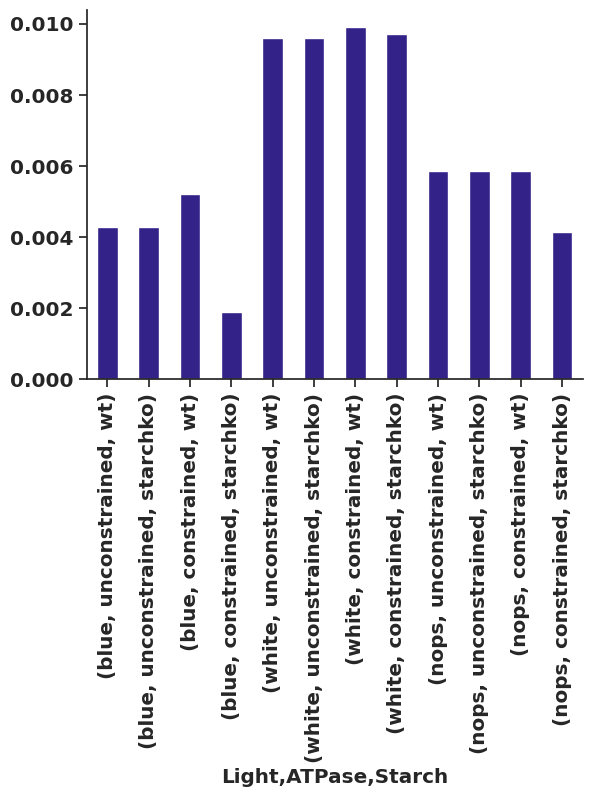

In [104]:
(pm_proton_pump + tonoplast_proton_pump).plot.bar()

In [105]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PHOSGLYPHOS_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000829
                      starchko    0.000829
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
nops   unconstrained  wt         -0.000725
                      starchko   -0.000725
       constrained    wt         -0.000563
                      starchko    0.000000
Name: (PHOSGLYPHOS_RXN_c_gc, 2), dtype: float64

In [106]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("2PGADEHYDRAT_RXN_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt         -0.000829
                      starchko   -0.000829
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt         -0.000897
                      starchko   -0.000897
       constrained    wt         -0.000754
                      starchko    0.000000
nops   unconstrained  wt          0.000725
                      starchko    0.000725
       constrained    wt          0.000563
                      starchko    0.000000
Name: (2PGADEHYDRAT_RXN_c_gc, 2), dtype: float64

MALATE_DEH_RXN_c_gc## Fraction is ATPase vs PPi for tonoplast

In [107]:
pm_proton_pump / (pm_proton_pump + tonoplast_proton_pump) * 100

Light  ATPase         Starch  
blue   unconstrained  wt           85.512953
                      starchko     85.513100
       constrained    wt          100.000000
                      starchko    100.000000
white  unconstrained  wt            0.000000
                      starchko      0.000000
       constrained    wt            0.330797
                      starchko      0.000000
nops   unconstrained  wt          100.000000
                      starchko    100.000000
       constrained    wt          100.000000
                      starchko    100.000000
dtype: float64

In [108]:
plastidatp_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (plastidatp_reactions, 2), :
]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/1889549114.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                       blue                       \
ATPase                             unconstrained          constrained   
Starch                                        wt starchko          wt   
Reaction                     Phase                                      
Plastidial_ATP_Synthase_p_gc 2               0.0      0.0         0.0   
PHOSGLYPHOS_RXN_p_gc         2               0.0      0.0         0.0   
ATP_ADP_Pi_pc_gc             2               0.0      0.0         0.0   
PHOSPHORIBULOKINASE_RXN_p_gc 2               0.0      0.0         0.0   

Light                                             white                  nops  \
ATPase                                      constrained           constrained   
Starch                             starchko          wt  starchko          wt   
Reaction                     Phase                                              
Plastidial_ATP_Synthase_p_gc 2          0.0    0.009819  0.009819         0.0   
PHOSGLYPHOS_RXN_p_gc         2          0.0    0.021037  0.020457         0.0   
ATP_ADP_Pi_pc_gc             2          0.0   -0.001723 -0.001743         0.0   
PHOSPHORIBULOKINASE_RXN_p_gc 2          0.0    0.010141  0.010742         0.0   

Light                                        
ATPase                                       
Starch                             starchko  
Reaction                     Phase           
Plastidial_ATP_Synthase_p_gc 2          0.0  
PHOSGLYPHOS_RXN_p_gc         2          0.0  
ATP_ADP_Pi_pc_gc             2          0.0  
PHOSPHORIBULOKINASE_RXN_p_gc 2          0.0

In [109]:
plastidatp_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (plastidatp_reactions, 3), :
]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/518837730.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                       blue                        \
ATPase                             unconstrained           constrained   
Starch                                        wt  starchko          wt   
Reaction                     Phase                                       
GLY3KIN_RXN_p_gc             3          0.000000  0.000000    0.000000   
Plastidial_ATP_Synthase_p_gc 3          0.009819  0.009819    0.009819   
GLUC1PADENYLTRANS_RXN_p_gc   3          0.000000  0.000000    0.000622   
PEPDEPHOS_RXN_p_gc           3          0.000000  0.000000    0.000000   
PHOSGLYPHOS_RXN_p_gc         3          0.021569  0.021569    0.021534   
ATP_ADP_Pi_pc_gc             3         -0.002932 -0.002932   -0.003478   
PHOSPHORIBULOKINASE_RXN_p_gc 3          0.010819  0.010819    0.010779   

Light                                              white            \
ATPase                                       constrained             
Starch                              starchko          wt  starchko   
Reaction                     Phase                                   
GLY3KIN_RXN_p_gc             3      0.000000    0.000000  0.000045   
Plastidial_ATP_Synthase_p_gc 3      0.009819    0.009819  0.009819   
GLUC1PADENYLTRANS_RXN_p_gc   3      0.000000    0.000587  0.000000   
PEPDEPHOS_RXN_p_gc           3      0.000000    0.000000  0.000000   
PHOSGLYPHOS_RXN_p_gc         3      0.021405    0.021531  0.021448   
ATP_ADP_Pi_pc_gc             3     -0.002659   -0.003443 -0.002737   
PHOSPHORIBULOKINASE_RXN_p_gc 3      0.010710    0.010782  0.010701   

Light                                     nops           
ATPase                             constrained           
Starch                                      wt starchko  
Reaction                     Phase                       
GLY3KIN_RXN_p_gc             3        0.000000      0.0  
Plastidial_ATP_Synthase_p_gc 3        0.000000      0.0  
GLUC1PADENYLTRANS_RXN_p_gc   3        0.000259      0.0  
PEPDEPHOS_RXN_p_gc           3        0.000070      0.0  
PHOSGLYPHOS_RXN_p_gc         3       -0.000023      0.0  
ATP_ADP_Pi_pc_gc             3       -0.000165      0.0  
PHOSPHORIBULOKINASE_RXN_p_gc 3        0.000000      0.0

In [110]:
plastidatp_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_3.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (plastidatp_reactions, 3), :
]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/2878871664.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                 blue                                  \
ATPase                       unconstrained           constrained             
Starch                                  wt  starchko          wt  starchko   
Reaction               Phase                                                 
PEPDEPHOS_RXN_c_gc     3          0.000000  0.000000    0.000000  0.000000   
FRUCTOKINASE_RXN_c_gc  3          0.000000  0.000000    0.000000  0.000614   
PROTON_ATPase_c_gc     3          0.000000  0.000000    0.000000  0.000000   
UDPKIN_RXN_c_gc        3          0.000884  0.000884    0.000581  0.001196   
ATP_ADP_mc_gc          3          0.003816  0.003816    0.004060  0.004469   
PEPCARBOXYKIN_RXN_c_gc 3          0.000000  0.000000    0.000000  0.000000   
ATP_ADP_Pi_pc_gc       3         -0.002932 -0.002932   -0.003478 -0.002659   
PHOSGLYPHOS_RXN_c_gc   3          0.000000  0.000000    0.000000  0.000000   

Light                              white                  nops            
ATPase                       constrained           constrained            
Starch                                wt  starchko          wt  starchko  
Reaction               Phase                                              
PEPDEPHOS_RXN_c_gc     3        0.000000  0.000000    0.000000  0.000079  
FRUCTOKINASE_RXN_c_gc  3        0.000000  0.000499    0.000328  0.000599  
PROTON_ATPase_c_gc     3        0.000000  0.000000    0.000305  0.000319  
UDPKIN_RXN_c_gc        3        0.000597  0.001152    0.000023  0.000280  
ATP_ADP_mc_gc          3        0.004040  0.004388    0.000822  0.001039  
PEPCARBOXYKIN_RXN_c_gc 3        0.000000  0.000000    0.000024  0.000000  
ATP_ADP_Pi_pc_gc       3       -0.003443 -0.002737   -0.000165  0.000000  
PHOSGLYPHOS_RXN_c_gc   3        0.000000  0.000000   -0.000023 -0.000079

In [111]:
plastidatp_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.NADPH_p_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (plastidatp_reactions, 3), :
]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/3324668440.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                                 blue            \
ATPase                                       unconstrained             
Starch                                                  wt  starchko   
Reaction                               Phase                           
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3          0.001341  0.001341   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3          0.021569  0.021569   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3          0.022910  0.022910   

Light                                                               \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.001377  0.001505   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.021534  0.021405   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.022910  0.022910   

Light                                              white            \
ATPase                                       constrained             
Starch                                                wt  starchko   
Reaction                               Phase                         
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3        0.001380  0.001463   
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3        0.021531  0.021448   
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3        0.022910  0.022910   

Light                                               nops           
ATPase                                       constrained           
Starch                                                wt starchko  
Reaction                               Phase                       
MALATE_DEHYDROGENASE_NADPs_RXN_p_gc    3             0.0      0.0  
1_PERIOD_2_PERIOD_1_PERIOD_13_RXN_p_gc 3             0.0      0.0  
1_PERIOD_18_PERIOD_1_PERIOD_2_RXN_p_gc 3             0.0      0.0

In [112]:
plastidatp_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.NADH_c_gc_2.reactions
]
plastidatp_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (plastidatp_reactions, 2), :
]
plastidatp_df = plastidatp_df.loc[~(abs(plastidatp_df) < 0.0000000001).all(axis=1)]
plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/1371925805.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  plastidatp_df.mask(abs(plastidatp_df) < 0.0000000001, 0).drop(


Light                                 blue                                 \
ATPase                       unconstrained           constrained            
Starch                                  wt  starchko          wt starchko   
Reaction               Phase                                                
MALATE_DEH_RXN_c_gc    2          0.000829  0.000829         0.0      0.0   
GAPOXNPHOSPHN_RXN_c_gc 2         -0.000829 -0.000829         0.0      0.0   

Light                              white                 nops           
ATPase                       constrained          constrained           
Starch                                wt starchko          wt starchko  
Reaction               Phase                                            
MALATE_DEH_RXN_c_gc    2             0.0      0.0   -0.000563      0.0  
GAPOXNPHOSPHN_RXN_c_gc 2             0.0      0.0    0.000563      0.0

In [113]:
0.003478 - 0.002659

0.0008190000000000003

In [114]:
0.020457 + 0.010742

0.031198999999999998

In [115]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[("PROTON_ATPase_c_gc", 2), :]

Light  ATPase         Starch  
blue   unconstrained  wt          0.008129
                      starchko    0.008129
       constrained    wt          0.004338
                      starchko    0.004338
white  unconstrained  wt          0.007747
                      starchko    0.007747
       constrained    wt          0.004338
                      starchko    0.004338
nops   unconstrained  wt          0.007963
                      starchko    0.007963
       constrained    wt          0.004338
                      starchko    0.004338
Name: (PROTON_ATPase_c_gc, 2), dtype: float64

In [116]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("MALATE_DEHYDROGENASE_NADPs_RXN_p_gc", 2), :
]

Light  ATPase         Starch  
blue   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
white  unconstrained  wt          0.002544
                      starchko    0.002544
       constrained    wt          0.001873
                      starchko    0.002453
nops   unconstrained  wt          0.000000
                      starchko    0.000000
       constrained    wt          0.000000
                      starchko    0.000000
Name: (MALATE_DEHYDROGENASE_NADPs_RXN_p_gc, 2), dtype: float64

/tmp/ipykernel_2392372/377450841.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1)


Text(0, 0.5, 'Flux (mmoles$\\cdot$m$^{-2}$$\\cdot$h$^{-1}$)')

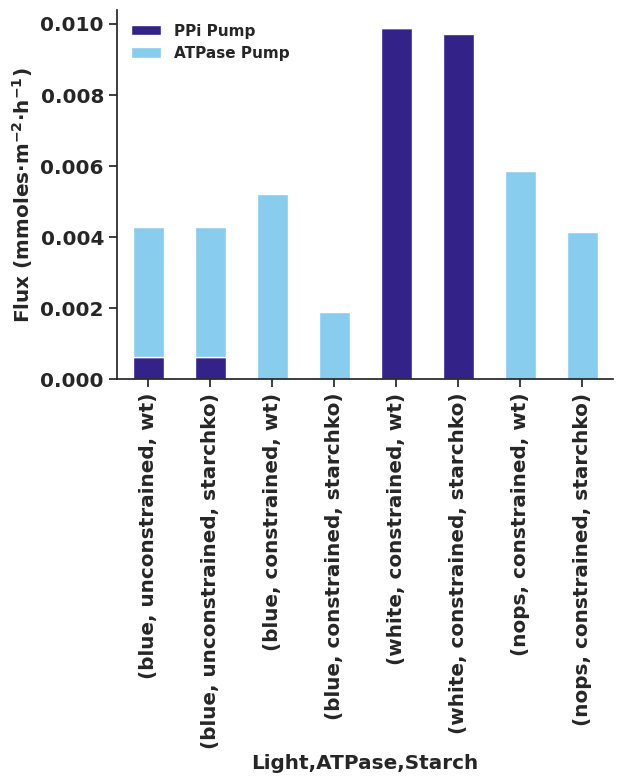

In [117]:
fig, ax = plt.subplots()

tonoplast_proton_transport_df = (
    solutions_df.xs("fluxes", level="Solution", axis=1)
    .loc[(["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :]
    .drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1)
)
tonoplast_proton_transport_df.index = ["PPi Pump", "ATPase Pump"]
tonoplast_proton_transport_df.T.plot(kind="bar", stacked=True, ax=ax)

ax.set_ylabel("Flux (mmoles$\cdot$m$^{-2}$$\cdot$h$^{-1}$)")

In [118]:
tonoplast_proton_transport_df

Light                blue                                       white  \
ATPase      unconstrained           constrained           constrained   
Starch                 wt  starchko          wt  starchko          wt   
PPi Pump         0.000622  0.000622    0.000000  0.000000    0.009862   
ATPase Pump      0.003670  0.003670    0.005218  0.001904    0.000033   

Light                        nops            
ATPase                constrained            
Starch       starchko          wt  starchko  
PPi Pump     0.009716    0.000000  0.000000  
ATPase Pump  0.000000    0.005844  0.004142

/tmp/ipykernel_2392372/4129036976.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[


<Axes: xlabel='Light,ATPase,Starch'>

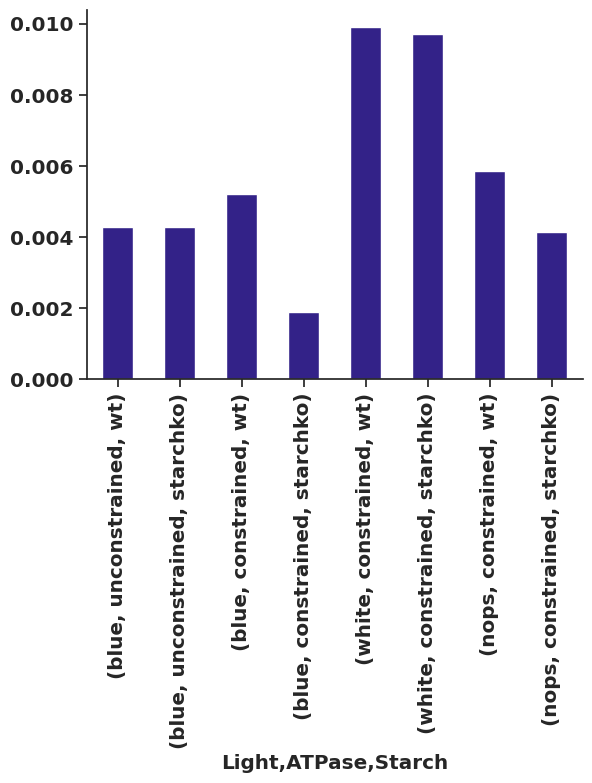

In [119]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (["PROTON_PPi_rev_vc_gc", "PROTONATP_rev_vc_gc"], 2), :
].drop([("white", "unconstrained"), ("nops", "unconstrained")], axis=1).sum().plot.bar()

In [120]:
ppi_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.PPI_c_gc_2.reactions
]
ppi_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(ppi_reactions, 2), :]
ppi_df = ppi_df.loc[~(abs(ppi_df) < 0.0000000001).all(axis=1)]
ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/211458224.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop(


Light                                                   blue            \
ATPase                                         unconstrained             
Starch                                                    wt  starchko   
Reaction                                 Phase                           
PROTON_PPi_rev_vc_gc                     2          0.000622  0.000622   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2          0.000000  0.000000   
GLUC1PURIDYLTRANS_RXN_c_gc               2          0.000207  0.000207   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2         -0.000415 -0.000415   

Light                                                                \
ATPase                                         constrained            
Starch                                                  wt starchko   
Reaction                                 Phase                        
PROTON_PPi_rev_vc_gc                     2             0.0      0.0   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2             0.0      0.0   
GLUC1PURIDYLTRANS_RXN_c_gc               2             0.0      0.0   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2             0.0      0.0   

Light                                                white            \
ATPase                                         constrained             
Starch                                                  wt  starchko   
Reaction                                 Phase                         
PROTON_PPi_rev_vc_gc                     2        0.009862  0.009716   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2        0.000000  0.000000   
GLUC1PURIDYLTRANS_RXN_c_gc               2        0.001034  0.001277   
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2       -0.008828 -0.008438   

Light                                                 nops           
ATPase                                         constrained           
Starch                                                  wt starchko  
Reaction                                 Phase                       
PROTON_PPi_rev_vc_gc                     2             0.0      0.0  
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2             0.0      0.0  
GLUC1PURIDYLTRANS_RXN_c_gc               2             0.0      0.0  
2_PERIOD_7_PERIOD_1_PERIOD_90_RXN_c_gc   2             0.0      0.0

In [121]:
ppi_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.PPI_p_gc_2.reactions
]
ppi_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[(ppi_reactions, 2), :]
ppi_df = ppi_df.loc[~(abs(ppi_df) < 0.0000000001).all(axis=1)]
ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/3029062637.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  ppi_df.mask(abs(ppi_df) < 0.0000000001, 0).drop(


Empty DataFrame
Columns: [(blue, unconstrained, wt), (blue, unconstrained, starchko), (blue, constrained, wt), (blue, constrained, starchko), (white, constrained, wt), (white, constrained, starchko), (nops, constrained, wt), (nops, constrained, starchko)]
Index: []

In [122]:
boundary_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.reactions
    if "_tx" in reaction.id
]
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("NITRATE_a_tx", slice(None)), :
]
nitrate_uptake

Light                       blue                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.018952  0.018952    0.018952  0.018952   
             2          0.056855  0.056855    0.056855  0.056855   
             3          0.307408  0.307408    0.307408  0.307408   
             4          0.012861  0.012861    0.012861  0.012861   

Light                      white                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.019835  0.019835    0.019835  0.019835   
             2          0.251324  0.251324    0.251324  0.251324   
             3          0.313542  0.313542    0.313542  0.313541   
             4          0.013183  0.013183    0.013183  0.013183   

Light                       nops                                  
ATPase             unconstrained           constrained            
Starch                        wt  starchko          wt  starchko  
Reaction     Phase                                                
NITRATE_a_tx 1          0.019831  0.019831    0.019831  0.019831  
             2          0.251274  0.251274    0.251274  0.251274  
             3          0.313480  0.313480    0.313479  0.313479  
             4          0.013181  0.013181    0.013181  0.013181

In [123]:
from mmon_gcm.analysing import get_phase_lengths

In [124]:
phase_lengths = get_phase_lengths(arabidopsis_supermodel.fba_model)
phase_lengths

[6.0, 0.5, 11.5, 6.0]

In [125]:
for i, phase_length in zip([1, 2, 3, 4], phase_lengths):
    nitrate_uptake.loc[("NITRATE_a_tx", i), :] = (
        nitrate_uptake.loc[("NITRATE_a_tx", i), :] * phase_length
    )
nitrate_uptake

Light                       blue                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.113710  0.113710    0.113710  0.113710   
             2          0.028428  0.028428    0.028428  0.028428   
             3          3.535195  3.535195    3.535194  3.535191   
             4          0.077167  0.077167    0.077167  0.077167   

Light                      white                                  \
ATPase             unconstrained           constrained             
Starch                        wt  starchko          wt  starchko   
Reaction     Phase                                                 
NITRATE_a_tx 1          0.119010  0.119010    0.119010  0.119010   
             2          0.125662  0.125662    0.125662  0.125662   
             3          3.605729  3.605729    3.605728  3.605724   
             4          0.079101  0.079101    0.079101  0.079101   

Light                       nops                                  
ATPase             unconstrained           constrained            
Starch                        wt  starchko          wt  starchko  
Reaction     Phase                                                
NITRATE_a_tx 1          0.118987  0.118987    0.118987  0.118987  
             2          0.125637  0.125637    0.125637  0.125637  
             3          3.605016  3.605016    3.605006  3.605004  
             4          0.079085  0.079085    0.079085  0.079085

In [126]:
nitrate_uptake_day = nitrate_uptake.loc[(slice(None), [2, 3]), :].sum()
nitrate_uptake_night = nitrate_uptake.loc[(slice(None), [1, 4]), :].sum()

In [127]:
nitrate_uptake_day

Light  ATPase         Starch  
blue   unconstrained  wt          3.563623
                      starchko    3.563623
       constrained    wt          3.563621
                      starchko    3.563619
white  unconstrained  wt          3.731391
                      starchko    3.731391
       constrained    wt          3.731390
                      starchko    3.731386
nops   unconstrained  wt          3.730653
                      starchko    3.730653
       constrained    wt          3.730643
                      starchko    3.730641
dtype: float64

In [128]:
nitrate_uptake_night

Light  ATPase         Starch  
blue   unconstrained  wt          0.190877
                      starchko    0.190877
       constrained    wt          0.190877
                      starchko    0.190877
white  unconstrained  wt          0.198111
                      starchko    0.198111
       constrained    wt          0.198111
                      starchko    0.198111
nops   unconstrained  wt          0.198072
                      starchko    0.198072
       constrained    wt          0.198071
                      starchko    0.198071
dtype: float64

In [129]:
nitrate_uptake_day / nitrate_uptake_night

Light  ATPase         Starch  
blue   unconstrained  wt          18.669741
                      starchko    18.669741
       constrained    wt          18.669741
                      starchko    18.669741
white  unconstrained  wt          18.834845
                      starchko    18.834845
       constrained    wt          18.834845
                      starchko    18.834845
nops   unconstrained  wt          18.834845
                      starchko    18.834845
       constrained    wt          18.834845
                      starchko    18.834845
dtype: float64

In [130]:
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("NITRATE_a_Linker", slice(None)), :
]
nitrate_uptake

Light                           blue                                \
ATPase                 unconstrained          constrained            
Starch                            wt starchko          wt starchko   
Reaction         Phase                                               
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0   
                 2               0.0      0.0         0.0      0.0   
                 3               0.0      0.0         0.0      0.0   
                 4               0.0      0.0         0.0      0.0   

Light                          white                                \
ATPase                 unconstrained          constrained            
Starch                            wt starchko          wt starchko   
Reaction         Phase                                               
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0   
                 2               0.0      0.0         0.0      0.0   
                 3               0.0      0.0         0.0      0.0   
                 4               0.0      0.0         0.0      0.0   

Light                           nops                                
ATPase                 unconstrained          constrained           
Starch                            wt starchko          wt starchko  
Reaction         Phase                                              
NITRATE_a_Linker 1               0.0      0.0         0.0      0.0  
                 2               0.0      0.0         0.0      0.0  
                 3               0.0      0.0         0.0      0.0  
                 4               0.0      0.0         0.0      0.0

In [131]:
nitrate_uptake = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("NITRATE_ae_me", slice(None)), :
]
nitrate_uptake

Light                        blue                                  \
ATPase              unconstrained           constrained             
Starch                         wt  starchko          wt  starchko   
Reaction      Phase                                                 
NITRATE_ae_me 1          0.018952  0.018952    0.018952  0.018952   
              2          0.056855  0.056855    0.056855  0.056855   
              3          0.307408  0.307408    0.307408  0.307408   
              4          0.012861  0.012861    0.012861  0.012861   

Light                       white                                  \
ATPase              unconstrained           constrained             
Starch                         wt  starchko          wt  starchko   
Reaction      Phase                                                 
NITRATE_ae_me 1          0.019835  0.019835    0.019835  0.019835   
              2          0.251324  0.251324    0.251324  0.251324   
              3          0.313542  0.313542    0.313542  0.313541   
              4          0.013183  0.013183    0.013183  0.013183   

Light                        nops                                  
ATPase              unconstrained           constrained            
Starch                         wt  starchko          wt  starchko  
Reaction      Phase                                                
NITRATE_ae_me 1          0.019831  0.019831    0.019831  0.019831  
              2          0.251274  0.251274    0.251274  0.251274  
              3          0.313480  0.313480    0.313479  0.313479  
              4          0.013181  0.013181    0.013181  0.013181

In [132]:
arabidopsis_supermodel.fba_model.metabolites.NITRATE_e_gc_2

Metabolite identifier,NITRATE_e_gc_2
Name,NITRATE_gc_2
Memory address,0x7f05a2640bb0
Formula,N1O3
Compartment,e
In 2 reaction(s),"NITRATE_ae_gc_2, Nitrate_ec_gc_2"


In [133]:
filtered_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.NADH_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (filtered_reactions, 2), :
]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/3396539403.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(


Light                                 blue                                 \
ATPase                       unconstrained           constrained            
Starch                                  wt  starchko          wt starchko   
Reaction               Phase                                                
MALATE_DEH_RXN_c_gc    2          0.000829  0.000829         0.0      0.0   
GAPOXNPHOSPHN_RXN_c_gc 2         -0.000829 -0.000829         0.0      0.0   

Light                              white                 nops           
ATPase                       constrained          constrained           
Starch                                wt starchko          wt starchko  
Reaction               Phase                                            
MALATE_DEH_RXN_c_gc    2             0.0      0.0   -0.000563      0.0  
GAPOXNPHOSPHN_RXN_c_gc 2             0.0      0.0    0.000563      0.0

In [134]:
filtered_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (filtered_reactions, 2), :
]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(
    [("white", "unconstrained"), ("nops", "unconstrained")], axis=1
)

/tmp/ipykernel_2392372/2619508033.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).drop(


Light                                                   blue            \
ATPase                                         unconstrained             
Starch                                                    wt  starchko   
Reaction                                 Phase                           
FRUCTOKINASE_RXN_c_gc                    2          0.000000  0.000000   
PEPDEPHOS_RXN_c_gc                       2          0.000768  0.000768   
ATP_ADP_mc_gc                            2          0.013664  0.013664   
6PFRUCTPHOS_RXN_c_gc                     2          0.000000  0.000000   
ATP_AMP_mc_gc                            2          0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc                   2          0.001597  0.001597   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2          0.000000  0.000000   
PROTONATP_rev_vc_gc                      2          0.003670  0.003670   
ATP_ADP_Pi_pc_gc                         2          0.000000  0.000000   
PROTON_ATPase_c_gc                       2          0.008129  0.008129   
UDPKIN_RXN_c_gc                          2          0.000207  0.000207   
PHOSGLYPHOS_RXN_c_gc                     2          0.000829  0.000829   

Light                                                                 \
ATPase                                         constrained             
Starch                                                  wt  starchko   
Reaction                                 Phase                         
FRUCTOKINASE_RXN_c_gc                    2        0.000000  0.000000   
PEPDEPHOS_RXN_c_gc                       2        0.000537  0.000351   
ATP_ADP_mc_gc                            2        0.009556  0.006242   
6PFRUCTPHOS_RXN_c_gc                     2        0.000000  0.000000   
ATP_AMP_mc_gc                            2        0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc                   2        0.000537  0.000351   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2        0.000000  0.000000   
PROTONATP_rev_vc_gc                      2        0.005218  0.001904   
ATP_ADP_Pi_pc_gc                         2        0.000000  0.000000   
PROTON_ATPase_c_gc                       2        0.004338  0.004338   
UDPKIN_RXN_c_gc                          2        0.000000  0.000000   
PHOSGLYPHOS_RXN_c_gc                     2        0.000000  0.000000   

Light                                                white            \
ATPase                                         constrained             
Starch                                                  wt  starchko   
Reaction                                 Phase                         
FRUCTOKINASE_RXN_c_gc                    2        0.000000  0.000000   
PEPDEPHOS_RXN_c_gc                       2        0.000000  0.000000   
ATP_ADP_mc_gc                            2        0.007882  0.007359   
6PFRUCTPHOS_RXN_c_gc                     2        0.000000  0.000000   
ATP_AMP_mc_gc                            2        0.000000  0.000000   
PEPCARBOXYKIN_RXN_c_gc                   2        0.000754  0.000000   
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc 2        0.000000  0.000000   
PROTONATP_rev_vc_gc                      2        0.000033  0.000000   
ATP_ADP_Pi_pc_gc                         2       -0.001723 -0.001743   
PROTON_ATPase_c_gc                       2        0.004338  0.004338   
UDPKIN_RXN_c_gc                          2        0.001034  0.001277   
PHOSGLYPHOS_RXN_c_gc                     2        0.000000  0.000000   

Light                                                 nops            
ATPase                                         constrained            
Starch                                                  wt  starchko  
Reaction                                 Phase                        
FRUCTOKINASE_RXN_c_gc                    2        0.000000  0.000000  
PEPDEPHOS_RXN_c_gc                       2        0.000000  0.000000  
ATP_ADP_mc_gc                            2        0.009901  0.008481  
6PFRUCTPHOS_

In [135]:
filtered_reactions = [
    reaction.id[:-2]
    for reaction in arabidopsis_supermodel.fba_model.metabolites.ATP_c_gc_2.reactions
]
filtered_df = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    (filtered_reactions, 2), :
]
filtered_df = filtered_df.loc[~(abs(filtered_df) < 0.0000000001).all(axis=1)]
filtered_df.mask(abs(filtered_df) < 0.0000000001, 0).loc[
    :, ("white", "constrained", "wt")
]

Reaction                                  Phase
FRUCTOKINASE_RXN_c_gc                     2        0.000000
PEPDEPHOS_RXN_c_gc                        2        0.000000
ATP_ADP_mc_gc                             2        0.007882
6PFRUCTPHOS_RXN_c_gc                      2        0.000000
ATP_AMP_mc_gc                             2        0.000000
PEPCARBOXYKIN_RXN_c_gc                    2        0.000754
PYRUVATEORTHOPHOSPHATE_DIKINASE_RXN_c_gc  2        0.000000
PROTONATP_rev_vc_gc                       2        0.000033
ATP_ADP_Pi_pc_gc                          2       -0.001723
PROTON_ATPase_c_gc                        2        0.004338
UDPKIN_RXN_c_gc                           2        0.001034
PHOSGLYPHOS_RXN_c_gc                      2        0.000000
Name: (white, constrained, wt), dtype: float64

In [136]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("PEPCARBOXYKIN_RXN_c_gc", 2), :
].drop([("white", "unconstrained"), ("nops", "unconstrained")])

/tmp/ipykernel_2392372/340511098.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  solutions_df.xs("fluxes", level="Solution", axis=1).loc[


Light  ATPase         Starch  
blue   unconstrained  wt          0.001597
                      starchko    0.001597
       constrained    wt          0.000537
                      starchko    0.000351
white  constrained    wt          0.000754
                      starchko    0.000000
nops   constrained    wt          0.000000
                      starchko    0.000000
Name: (PEPCARBOXYKIN_RXN_c_gc, 2), dtype: float64

In [137]:
phloem_outputs = solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("Phloem_tx_overall", np.nan), :
]

In [138]:
phloem_outputs

Light  ATPase         Starch  
blue   unconstrained  wt          15.179976
                      starchko    15.179976
       constrained    wt          15.179970
                      starchko    15.179958
white  unconstrained  wt          15.887536
                      starchko    15.887536
       constrained    wt          15.887530
                      starchko    15.887515
nops   unconstrained  wt          15.884392
                      starchko    15.884392
       constrained    wt          15.884351
                      starchko    15.884343
Name: (Phloem_tx_overall, nan), dtype: float64

In [139]:
phloem_outputs_dict = {}
for name, value in phloem_outputs.items():
    phloem_outputs_dict[name] = (phloem_outputs / value * 100).round(3)

In [140]:
phloem_outputs_comparison_table = pd.DataFrame.from_dict(phloem_outputs_dict)
phloem_outputs_comparison_table.to_csv(
    "../outputs/efficiency_comparisons/phloem_outputs_compare.csv"
)
phloem_outputs_comparison_table

blue                                \
                             unconstrained          constrained            
                                        wt starchko          wt starchko   
Light ATPase        Starch                                                 
blue  unconstrained wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
      constrained   wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
white unconstrained wt             104.661  104.661     104.661  104.661   
                    starchko       104.661  104.661     104.661  104.661   
      constrained   wt             104.661  104.661     104.661  104.661   
                    starchko       104.661  104.661     104.661  104.661   
nops  unconstrained wt             104.640  104.640     104.640  104.641   
                    starchko       104.640  104.640     104.640  104.641   
      constrained   wt             104.640  104.640     104.640  104.640   
                    starchko       104.640  104.640     104.640  104.640   

                                     white                                \
                             unconstrained          constrained            
                                        wt starchko          wt starchko   
Light ATPase        Starch                                                 
blue  unconstrained wt              95.546   95.546      95.546   95.547   
                    starchko        95.546   95.546      95.546   95.547   
      constrained   wt              95.546   95.546      95.546   95.547   
                    starchko        95.546   95.546      95.546   95.546   
white unconstrained wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
      constrained   wt             100.000  100.000     100.000  100.000   
                    starchko       100.000  100.000     100.000  100.000   
nops  unconstrained wt              99.980   99.980      99.980   99.980   
                    starchko        99.980   99.980      99.980   99.980   
      constrained   wt              99.980   99.980      99.980   99.980   
                    starchko        99.980   99.980      99.980   99.980   

                                      nops                                
                             unconstrained          constrained           
                                        wt starchko          wt starchko  
Light ATPase        Starch                                                
blue  unconstrained wt              95.565   95.565      95.566   95.566  
                    starchko        95.565   95.565      95.566   95.566  
      constrained   wt              95.565   95.565      95.566   95.566  
                    starchko        95.565   95.565      95.565   95.566  
white unconstrained wt             100.020  100.020     100.020  100.020  
                    starchko       100.020  100.020     100.020  100.020  
      constrained   wt             100.020  100.020     100.020  100.020  
                    starchko       100.020  100.020     100.020  100.020  
nops  unconstrained wt             100.000  100.000     100.000  100.000  
                    starchko       100.000  100.000     100.000  100.000  
      constrained   wt             100.000  100.000     100.000  100.000  
                    starchko       100.000  100.000     100.000  100.000

In [141]:
100 - 99.980

0.01999999999999602

In [142]:
phloem_outputs_blue = phloem_outputs.loc["blue"]
phloem_outputs_blue / phloem_outputs_blue.iloc[0] * 100

ATPase         Starch  
unconstrained  wt          100.000000
               starchko    100.000000
constrained    wt           99.999963
               starchko     99.999883
Name: (Phloem_tx_overall, nan), dtype: float64

In [143]:
phloem_outputs_white = phloem_outputs.drop("blue")
phloem_outputs_white = phloem_outputs_white / phloem_outputs_white.iloc[0] * 100
phloem_outputs_white

/tmp/ipykernel_2392372/3118140255.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  phloem_outputs_white = phloem_outputs.drop("blue")


Light  ATPase         Starch  
white  unconstrained  wt          100.000000
                      starchko    100.000000
       constrained    wt           99.999957
                      starchko     99.999863
nops   unconstrained  wt           99.980210
                      starchko     99.980210
       constrained    wt           99.979949
                      starchko     99.979901
Name: (Phloem_tx_overall, nan), dtype: float64

In [144]:
phloem_outputs.drop("blue")

/tmp/ipykernel_2392372/4124221444.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  phloem_outputs.drop("blue")


Light  ATPase         Starch  
white  unconstrained  wt          15.887536
                      starchko    15.887536
       constrained    wt          15.887530
                      starchko    15.887515
nops   unconstrained  wt          15.884392
                      starchko    15.884392
       constrained    wt          15.884351
                      starchko    15.884343
Name: (Phloem_tx_overall, nan), dtype: float64

<Axes: xlabel='Light,ATPase,Starch'>

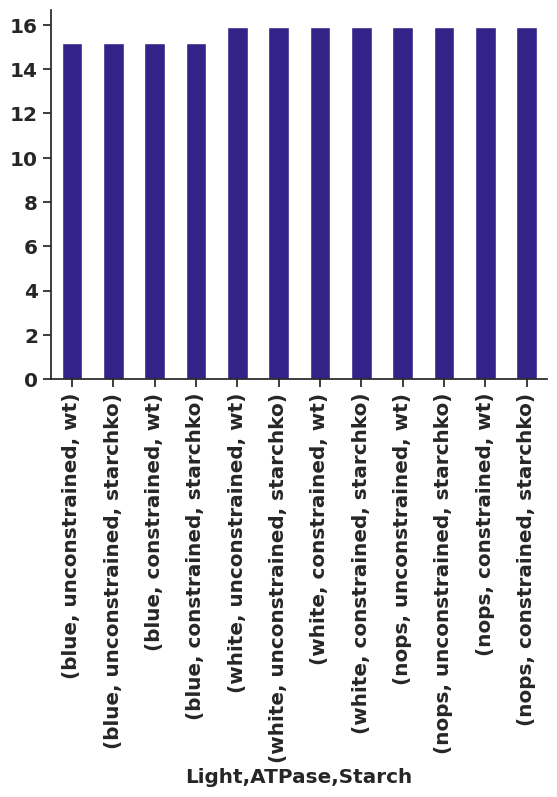

In [145]:
solutions_df.xs("fluxes", level="Solution", axis=1).loc[
    ("Phloem_tx_overall", np.nan), :
].plot.bar()